# Feature Selection


# 1.0 Load Data

Import dataset

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
import numpy as np

# Load the dataset
file_path = '../processed_data/data_v4-1-1_feature_engineered_sensor210.csv'
data = pd.read_csv(file_path)

Given the feature engineered data have 282 data but theres only 100~ data point which might make it hard to do feature selection. Therefore we will be dividing up into each feature engineered category and eliminate highly correlated features. 

In [2]:
data.shape

(210, 283)

In [3]:
print(data.columns)

Index(['Sensor ID', '13_10000_mean_middle', '13_16800_mean_middle',
       '13_3000_mean_middle', '13_6000_mean_middle', '13_8000_mean_middle',
       '18_10000_mean_middle', '18_16800_mean_middle', '18_3000_mean_middle',
       '18_6000_mean_middle',
       ...
       '48_10000_var_upper', '48_16800_var_upper', '48_3000_var_upper',
       '48_6000_var_upper', '48_8000_var_upper', '53_10000_var_upper',
       '53_16800_var_upper', '53_3000_var_upper', '53_6000_var_upper',
       '53_8000_var_upper'],
      dtype='object', length=283)


Getting the data ready

In [4]:
# Function to slice features by keyword while maintaining the ID column
def slice_features_by_keyword(df, keyword, id_col='Sensor ID'):
    """
    Slices the features from the DataFrame that contain the given keyword while maintaining the ID column.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    keyword (str): The keyword to filter the column names.
    id_col (str): The name of the ID column to retain. Default is 'Sensor ID'.

    Returns:
    pd.DataFrame: A DataFrame containing only the columns that contain the keyword and the ID column.
    """
    print(keyword)
    # Select columns that contain the keyword
    keyword_columns = df.columns[df.columns.str.contains(keyword)]
    
    # Combine the ID column with the keyword columns
    columns_to_keep = [id_col] + list(keyword_columns)
    
    # Select the columns from the DataFrame
    sliced_df = df[columns_to_keep]
    
    return sliced_df

# 2.0 Use of Correlation
Correlation measures the strength and direction of the linear relationship between two variables.

Drop Highly Correlated Features: Remove highly correlated features to reduce redundancy.

In [5]:
# Function to drop highly positively correlated features
def drop_highly_correlated_features(df, threshold=0.8):
    corr_matrix = df.corr()
    to_drop = set()
    for i in range(corr_matrix.shape[0]):
        for j in range(i + 1, corr_matrix.shape[1]):
            if corr_matrix.iloc[i, j] > threshold:
                colname = corr_matrix.columns[j]
                to_drop.add(colname)
    reduced_df = df.drop(columns=to_drop)
    print(f"Number of Feature Dropped is {len(list(to_drop))}. Number of Features Remained is {reduced_df.shape[1]}")
    return reduced_df, list(to_drop)

In [6]:
df_mean_middle = slice_features_by_keyword(data,"16800_mean_middle")
df_mean_middle.head()

16800_mean_middle


Sensor ID  13_16800_mean_middle  18_16800_mean_middle  \
0          1            827.000000           1069.285714   
1          2            679.000000            954.200000   
2          3            717.727273           1020.920000   
3          4            736.840000           1031.000000   
4          5            742.894737           1045.697674   

   23_16800_mean_middle  28_16800_mean_middle  33_16800_mean_middle  \
0           1302.076923           1590.384615           1959.000000   
1           1247.560000           1522.920000           1811.363636   
2           1296.674419           1584.244444           1888.600000   
3           1319.000000           1628.469388           1923.000000   
4           1332.760000           1587.480000           1902.441860   

   38_16800_mean_middle  43_16800_mean_middle  48_16800_mean_middle  \
0           2204.040000           2434.520000           2737.000000   
1           2098.744681           2373.200000           2679.320000   
2           2147.640000           2443.326531           2721.480000   
3           2242.200000           2485.325581           2753.800000   
4           2173.638298           2457.800000           2732.181818   

   53_16800_mean_middle  
0           3006.500000  
1           1855.878049  
2           2992.840000  
3           2999.608696  
4           3058.440000

In [7]:
# Drop highly correlated features
df_mean_middle_reduced, dropped_features = drop_highly_correlated_features(df_mean_middle, threshold=0.8)

print(dropped_features)

Number of Feature Dropped is 3. Number of Features Remained is 7
['38_16800_mean_middle', '48_16800_mean_middle', '43_16800_mean_middle']


In [8]:
df_mean_middle_reduced.head()

Sensor ID  13_16800_mean_middle  18_16800_mean_middle  \
0          1            827.000000           1069.285714   
1          2            679.000000            954.200000   
2          3            717.727273           1020.920000   
3          4            736.840000           1031.000000   
4          5            742.894737           1045.697674   

   23_16800_mean_middle  28_16800_mean_middle  33_16800_mean_middle  \
0           1302.076923           1590.384615           1959.000000   
1           1247.560000           1522.920000           1811.363636   
2           1296.674419           1584.244444           1888.600000   
3           1319.000000           1628.469388           1923.000000   
4           1332.760000           1587.480000           1902.441860   

   53_16800_mean_middle  
0           3006.500000  
1           1855.878049  
2           2992.840000  
3           2999.608696  
4           3058.440000

In [9]:
# Function to process data in batches and remove highly correlated features within each batch
def process_batches(df, keywords, id_col='Sensor ID', threshold=0.8):
    """
    Processes data in batches based on keywords, removing highly correlated features within each batch.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    keywords (list): List of keywords to filter the column names for each batch.
    id_col (str): The name of the ID column to retain. Default is 'Sensor ID'.
    threshold (float): The correlation threshold for dropping features. Defaults to 0.8.

    Returns:
    pd.DataFrame: A DataFrame containing the processed batches with reduced features.
    """
    processed_batches = []

    for keyword in keywords:
        sliced_data = slice_features_by_keyword(df, keyword, id_col)
        reduced_data,_ = drop_highly_correlated_features(sliced_data, threshold)
        processed_batches.append(reduced_data)

    # Combine the processed batches, ensuring to merge on the ID column
    final_df = pd.concat(processed_batches, axis=1)
    
    # Remove duplicate ID columns that might have been introduced during concatenation
    final_df = final_df.loc[:, ~final_df.columns.duplicated()]

    return final_df

def get_batch_feature_name(keyword):
    features = []
    for delay in [16800,10000,8000,6000,3000]:
        features.append(f"{delay}_{keyword}")
    return features

## Mean Range Delay features 

In [10]:
mean_middle = get_batch_feature_name("mean_middle")
df_mean_middle  = process_batches(data,mean_middle,threshold=0.8)
df_mean_middle

16800_mean_middle
Number of Feature Dropped is 3. Number of Features Remained is 7
10000_mean_middle
Number of Feature Dropped is 5. Number of Features Remained is 5
8000_mean_middle
Number of Feature Dropped is 4. Number of Features Remained is 6
6000_mean_middle
Number of Feature Dropped is 5. Number of Features Remained is 5
3000_mean_middle
Number of Feature Dropped is 6. Number of Features Remained is 4


Sensor ID  13_16800_mean_middle  18_16800_mean_middle  \
0            1            827.000000           1069.285714   
1            2            679.000000            954.200000   
2            3            717.727273           1020.920000   
3            4            736.840000           1031.000000   
4            5            742.894737           1045.697674   
..         ...                   ...                   ...   
205        207            723.080000           1026.760000   
206        208            720.120000           1009.883721   
207        209            748.551020           1053.875000   
208        210            732.360000           1018.744681   
209        211            307.512821           1008.920000   

     23_16800_mean_middle  28_16800_mean_middle  33_16800_mean_middle  \
0             1302.076923           1590.384615           1959.000000   
1             1247.560000           1522.920000           1811.363636   
2             1296.674419           1584.244444           1888.600000   
3             1319.000000           1628.469388           1923.000000   
4             1332.760000           1587.480000           1902.441860   
..                    ...                   ...                   ...   
205           1307.170213           1580.250000           1878.760000   
206           1296.444444           1582.090909           1871.560000   
207           1345.080000           1617.400000           1928.360000   
208           1309.000000           1567.000000           1883.900000   
209            722.346939           1562.520000           1887.400000   

     53_16800_mean_middle  13_10000_mean_middle  18_10000_mean_middle  \
0             3006.500000            827.000000           1071.000000   
1             1855.878049            679.640000            943.000000   
2             2992.840000            717.880000           1029.933333   
3             2999.608696            737.080000           1030.351351   
4             3058.440000            743.000000           1046.102041   
..                    ...                   ...                   ...   
205           3018.840000            709.560000           1033.400000   
206           3007.320000            719.897959           1009.880000   
207           3057.800000            759.000000           1070.040000   
208           3014.000000            722.200000           1019.000000   
209           2815.400000            715.000000           1027.897959   

     23_10000_mean_middle  ...  38_8000_mean_middle  43_8000_mean_middle  \
0             1303.000000  ...          2248.120000          2443.880000   
1             1235.000000  ...          2117.720000          2381.160000   
2             1297.212766  ...          2163.916667          2440.920000   
3             1317.640000  ...          2224.040000          2486.404255   
4             1333.480000  ...          2173.400000          2471.000000   
..                    ...  ...                  ...                  ...   
205           1307.000000  ...          2170.840000          2453.638298   
206           1296.727273  ...          2168.600000          2446.600000   
207           1334.707317  ...          2202.200000          2497.742857   
208           1303.000000  ...          2173.960000          2453.080000   
209           1304.120000  ...          2160.130435          2448.600000   

     53_8000_mean_middle  13_6000_mean_middle  18_6000_mean_middle  \
0            2995.000000           827.000000          1069.400000   
1            1891.240000           679.000000           954.520000   
2            2997.320000           717.240000          1005.960000   
3            2999.000000           736.920000          1087.000000   
4            2110.760000           743.000000          1046.288889   
..                   ...                  ...                  ...   
205          3028.760000           709.480000          1033.000000   
206          2995.720000         

In [11]:
mean_lower = get_batch_feature_name("mean_lower")

df_mean_lower  = process_batches(data,mean_lower,threshold=0.8)
df_mean_lower

16800_mean_lower
Number of Feature Dropped is 0. Number of Features Remained is 10
10000_mean_lower
Number of Feature Dropped is 0. Number of Features Remained is 10
8000_mean_lower
Number of Feature Dropped is 0. Number of Features Remained is 10
6000_mean_lower
Number of Feature Dropped is 0. Number of Features Remained is 10
3000_mean_lower
Number of Feature Dropped is 0. Number of Features Remained is 10


Sensor ID  13_16800_mean_lower  18_16800_mean_lower  23_16800_mean_lower  \
0            1           826.166667          1059.000000             0.000000   
1            2           678.600000             0.000000             0.000000   
2            3             0.000000             0.000000             0.000000   
3            4             0.000000          1029.818182          1317.933333   
4            5           718.333333          1024.142857             0.000000   
..         ...                  ...                  ...                  ...   
205        207             0.000000             0.000000          1284.333333   
206        208             0.000000             0.000000          1273.000000   
207        209             0.000000          1029.909091             0.000000   
208        210             0.000000             0.000000             0.000000   
209        211             0.000000             0.000000             0.000000   

     28_16800_mean_lower  33_16800_mean_lower  38_16800_mean_lower  \
0                    0.0          1958.255814             0.000000   
1                    0.0             0.000000          1929.666667   
2                 1561.4             0.000000             0.000000   
3                    0.0          1922.789474             0.000000   
4                    0.0          1876.333333             0.000000   
..                   ...                  ...                  ...   
205                  0.0             0.000000             0.000000   
206               1559.0             0.000000             0.000000   
207                  0.0             0.000000          2201.000000   
208                  0.0             0.000000          2159.000000   
209                  0.0             0.000000             0.000000   

     43_16800_mean_lower  48_16800_mean_lower  53_16800_mean_lower  ...  \
0               0.000000               2712.5               2835.0  ...   
1            2351.500000                  0.0               1551.0  ...   
2            2403.000000                  0.0                  0.0  ...   
3            2463.571429                  0.0               2969.0  ...   
4               0.000000                  0.0                  0.0  ...   
..                   ...                  ...                  ...  ...   
205             0.000000                  0.0                  0.0  ...   
206             0.000000               2667.0                  0.0  ...   
207             0.000000               2732.0                  0.0  ...   
208             0.000000                  0.0               2984.0  ...   
209             0.000000               2507.0                  0.0  ...   

     53_6000_mean_lower  13_3000_mean_lower  18_3000_mean_lower  \
0              0.000000          826.346939            0.000000   
1           2950.363636          678.500000          943.000000   
2              0.000000            0.000000         1005.736842   
3           2998.200000            0.000000            0.000000   
4              0.000000            0.000000         1023.000000   
..                  ...                 ...                 ...   
205            0.000000            0.000000            0.000000   
206            0.000000            0.000000            0.000000   
207            0.000000          758.600000            0.000000   
208            0.000000          721.769231            0.000000   
209            0.000000          691.000000         1005.000000   

     23_3000_mean_lower  28_3000_mean_lower  33_3000_mean_lower  \
0              0.000000            0.000000         1957.731707   
1           1234.911111            0.000000         1838.024390   
2              0.000000            0.000000            0.000000   
3              0.000000            0.000000         1922.684211   
4              0.000000         1593.857143         1902.500000   
..                  ...                 ...                 ...   
205         1305

In [12]:
mean_upper = get_batch_feature_name("mean_upper")
df_mean_upper  = process_batches(data,mean_upper,threshold=0.8)
df_mean_upper

16800_mean_upper
Number of Feature Dropped is 0. Number of Features Remained is 10
10000_mean_upper
Number of Feature Dropped is 0. Number of Features Remained is 10
8000_mean_upper
Number of Feature Dropped is 0. Number of Features Remained is 10
6000_mean_upper
Number of Feature Dropped is 0. Number of Features Remained is 10
3000_mean_upper
Number of Feature Dropped is 0. Number of Features Remained is 10


Sensor ID  13_16800_mean_upper  18_16800_mean_upper  23_16800_mean_upper  \
0            1           827.195122             0.000000          1353.545455   
1            2           679.869565             0.000000             0.000000   
2            3           742.333333             0.000000          1320.714286   
3            4             0.000000          1042.263158          1319.526316   
4            5             0.000000             0.000000             0.000000   
..         ...                  ...                  ...                  ...   
205        207             0.000000             0.000000             0.000000   
206        208             0.000000          1033.857143          1321.000000   
207        209           815.000000          1079.571429             0.000000   
208        210             0.000000          1043.000000             0.000000   
209        211         65535.000000             0.000000         65535.000000   

     28_16800_mean_upper  33_16800_mean_upper  38_16800_mean_upper  \
0            1639.727273          1959.666667             0.000000   
1               0.000000          1835.666667             0.000000   
2               0.000000             0.000000             0.000000   
3            1687.000000          1924.000000             0.000000   
4               0.000000          1927.000000          2199.000000   
..                   ...                  ...                  ...   
205          1601.000000             0.000000             0.000000   
206             0.000000             0.000000          2186.666667   
207             0.000000             0.000000          2248.714286   
208          1587.800000          1913.000000          2197.666667   
209             0.000000             0.000000             0.000000   

     43_16800_mean_upper  48_16800_mean_upper  53_16800_mean_upper  ...  \
0               0.000000                  0.0             0.000000  ...   
1            2397.000000                  0.0          2371.000000  ...   
2               0.000000                  0.0             0.000000  ...   
3               0.000000                  0.0          3019.000000  ...   
4               0.000000               2755.0             0.000000  ...   
..                   ...                  ...                  ...  ...   
205             0.000000                  0.0             0.000000  ...   
206             0.000000                  0.0             0.000000  ...   
207          2520.333333               2782.0             0.000000  ...   
208             0.000000                  0.0          3037.666667  ...   
209             0.000000                  0.0             0.000000  ...   

     53_6000_mean_upper  13_3000_mean_upper  18_3000_mean_upper  \
0           3039.727273          827.095238            0.000000   
1           2951.744186          679.888889          975.000000   
2              0.000000            0.000000         1008.684211   
3           2999.930233            0.000000            0.000000   
4              0.000000            0.000000            0.000000   
..                  ...                 ...                 ...   
205            0.000000          727.000000            0.000000   
206            0.000000            0.000000            0.000000   
207            0.000000          759.869565            0.000000   
208            0.000000          724.128205            0.000000   
209            0.000000          743.000000            0.000000   

     23_3000_mean_upper  28_3000_mean_upper  33_3000_mean_upper  \
0              0.000000            0.000000         1959.923077   
1           1235.408163            0.000000         1839.857143   
2              0.000000         1583.666667            0.000000   
3              0.000000            0.000000         1924.021277   
4              0.000000         1595.842105         1903.181818   
..                  ...                 ...                 ...   
205         1307

## Variability Range Delay features 

In [13]:
var_middle = get_batch_feature_name("var_middle")
df_var_middle  = process_batches(data,var_middle,threshold=0.8)
df_var_middle

16800_var_middle
Number of Feature Dropped is 5. Number of Features Remained is 5
10000_var_middle
Number of Feature Dropped is 0. Number of Features Remained is 10
8000_var_middle
Number of Feature Dropped is 0. Number of Features Remained is 10
6000_var_middle
Number of Feature Dropped is 0. Number of Features Remained is 10
3000_var_middle
Number of Feature Dropped is 7. Number of Features Remained is 3


Sensor ID  13_16800_var_middle  18_16800_var_middle  23_16800_var_middle  \
0            1             0.000000             5.333333             6.283401   
1            2             0.000000           189.387755           172.414694   
2            3             5.040169           136.646531             6.272425   
3            4             6.014694             0.000000             0.000000   
4            5             6.475107             8.168328             5.982041   
..         ...                  ...                  ...                  ...   
205        207           157.054694           111.288163             7.622572   
206        208             5.903673             7.867110             8.368254   
207        209           200.544218             4.370968           262.034286   
208        210           148.643265             7.933395           239.183673   
209        211        111470.993252           419.422041        295598.897959   

     28_16800_var_middle  13_10000_var_middle  18_10000_var_middle  \
0               3.821862             0.000000             0.000000   
1             129.626122             5.459592             0.000000   
2               6.416162             4.597551             4.654545   
3             399.129252             4.075102             3.123123   
4             140.826122             0.000000             8.843537   
..                   ...                  ...                  ...   
205             8.276596             5.720816             5.224490   
206             6.596195             4.176871             9.822041   
207           212.244898             0.000000           145.345306   
208             5.818182             6.530612             0.000000   
209           146.703673             0.000000             7.510204   

     23_10000_var_middle  28_10000_var_middle  33_10000_var_middle  ...  \
0               0.000000             0.000000             0.000000  ...   
1               0.000000             9.933061             0.000000  ...   
2               8.214616             6.801418             5.224490  ...   
3               7.582041          1528.842449             4.176871  ...   
4               7.764898             9.900408             0.000000  ...   
..                   ...                  ...                  ...  ...   
205             0.000000             6.328163             0.000000  ...   
206             6.249471             0.000000           149.916735  ...   
207             6.712195           158.569796           132.989388  ...   
208             0.000000           142.373878             6.624855  ...   
209           122.148571             0.000000             7.582041  ...   

     18_6000_var_middle  23_6000_var_middle  28_6000_var_middle  \
0              6.530612          693.714286            0.000000   
1            164.336327            0.000000            3.977143   
2              7.712653            4.573737            5.432007   
3             35.096774            6.987440            4.460882   
4              5.301010            6.687347            4.760816   
..                  ...                 ...                 ...   
205            5.387755            0.000000            6.295510   
206            9.959184          120.973061            5.358002   
207          140.408163            8.822695            9.568106   
208            9.324699            5.212766            0.000000   
209            7.732245          125.544490            0.000000   

     33_6000_var_middle  38_6000_var_middle  43_6000_var_middle  \
0              0.000000            0.000000            6.896327   
1              0.000000          135.471020            4.801772   
2              7.288163            6.556735          114.390204   
3              4.448980            0.000000          136.888163   
4              0.000000            4.037787            0.000000   
..                  ...                 ...                 ...   
205            5

In [14]:
var_lower = get_batch_feature_name("var_lower")
df_var_lower  = process_batches(data,var_lower,threshold=0.8)
df_var_lower

16800_var_lower
Number of Feature Dropped is 1. Number of Features Remained is 9
10000_var_lower
Number of Feature Dropped is 0. Number of Features Remained is 10
8000_var_lower
Number of Feature Dropped is 0. Number of Features Remained is 10
6000_var_lower
Number of Feature Dropped is 1. Number of Features Remained is 9
3000_var_lower
Number of Feature Dropped is 0. Number of Features Remained is 10


Sensor ID  13_16800_var_lower  18_16800_var_lower  23_16800_var_lower  \
0            1            3.375887            0.000000            0.000000   
1            2            1.476923            0.000000            0.000000   
2            3            0.000000            0.000000            0.000000   
3            4            0.000000            4.152220            3.200000   
4            5            5.333333            9.142857            0.000000   
..         ...                 ...                 ...                 ...   
205        207            0.000000            0.000000            5.333333   
206        208            0.000000            0.000000            4.800000   
207        209            0.000000            3.490909            0.000000   
208        210            0.000000            0.000000            0.000000   
209        211            0.000000            0.000000            0.000000   

     33_16800_var_lower  38_16800_var_lower  43_16800_var_lower  \
0              2.480620            0.000000            0.000000   
1              0.000000         4229.333333           29.428571   
2              0.000000            0.000000            0.000000   
3              0.819346            0.000000            2.285714   
4              5.333333            0.000000            0.000000   
..                  ...                 ...                 ...   
205            0.000000            0.000000            0.000000   
206            0.000000            0.000000            0.000000   
207            0.000000            8.000000            0.000000   
208            0.000000            0.000000            0.000000   
209            0.000000            0.000000            0.000000   

     48_16800_var_lower  53_16800_var_lower  13_10000_var_lower  ...  \
0              4.285714            0.000000            1.724082  ...   
1              0.000000        16480.000000            0.000000  ...   
2              0.000000            0.000000            0.000000  ...   
3              0.000000            8.000000            0.000000  ...   
4              0.000000            0.000000            2.232558  ...   
..                  ...                 ...                 ...  ...   
205            0.000000            0.000000            0.000000  ...   
206            0.000000            0.000000            0.000000  ...   
207            9.090909            0.000000            3.179704  ...   
208            0.000000           78.666667            0.000000  ...   
209            0.000000            0.000000            2.677463  ...   

     48_6000_var_lower  13_3000_var_lower  18_3000_var_lower  \
0             0.000000           2.231293           0.000000   
1             0.000000           1.794872           0.000000   
2             4.444444           0.000000           3.550498   
3            30.734694           0.000000           0.000000   
4             0.000000           0.000000           0.000000   
..                 ...                ...                ...   
205           0.000000           0.000000           0.000000   
206           0.000000           0.000000           0.000000   
207           0.000000           1.476923           0.000000   
208           0.000000           4.340081           0.000000   
209           0.000000           0.000000           5.333333   

     23_3000_var_lower  28_3000_var_lower  33_3000_var_lower  \
0             0.000000           0.000000           5.151220   
1             0.355556           0.000000           4.624390   
2             0.000000           0.000000           0.000000   
3             0.000000           0.000000           1.194879   
4             0.000000           3.344948           1.787234   
..                 ...                ...                ...   
205           5.581395           0.000000           0.000000   
206           0.000000           3.260459           0.000000   
207           0.000000           0.000000           0

In [15]:
var_upper = get_batch_feature_name("var_upper")
df_var_upper  = process_batches(data,var_upper,threshold=0.8)
df_var_upper

16800_var_upper
Number of Feature Dropped is 2. Number of Features Remained is 8
10000_var_upper
Number of Feature Dropped is 0. Number of Features Remained is 10
8000_var_upper
Number of Feature Dropped is 0. Number of Features Remained is 10
6000_var_upper
Number of Feature Dropped is 0. Number of Features Remained is 10
3000_var_upper
Number of Feature Dropped is 0. Number of Features Remained is 10


Sensor ID  13_16800_var_upper  18_16800_var_upper  23_16800_var_upper  \
0            1            0.760976            0.000000            4.072727   
1            2            2.782609            0.000000            0.000000   
2            3            2.666667            0.000000            4.571429   
3            4            0.000000          696.091038            1.877667   
4            5            0.000000            0.000000            0.000000   
..         ...                 ...                 ...                 ...   
205        207            0.000000            0.000000            0.000000   
206        208            0.000000            3.809524            4.571429   
207        209            0.000000            2.285714            0.000000   
208        210            0.000000           16.000000            0.000000   
209        211            0.000000            0.000000            0.000000   

     28_16800_var_upper  33_16800_var_upper  38_16800_var_upper  \
0              2.618182            2.276423            0.000000   
1              0.000000           15.466667            0.000000   
2              0.000000            0.000000            0.000000   
3              0.000000            3.063830            0.000000   
4              0.000000           10.666667            0.000000   
..                  ...                 ...                 ...   
205            8.000000            0.000000            0.000000   
206            0.000000            0.000000            7.151515   
207            0.000000            0.000000            4.571429   
208            3.200000          114.666667            5.333333   
209            0.000000            0.000000            0.000000   

     43_16800_var_upper  13_10000_var_upper  18_10000_var_upper  ...  \
0              0.000000            0.000000            0.000000  ...   
1              8.000000            0.000000           19.487179  ...   
2              0.000000            0.000000            0.000000  ...   
3              0.000000            0.000000           44.606061  ...   
4              0.000000            2.232558            0.000000  ...   
..                  ...                 ...                 ...  ...   
205            0.000000            0.000000            0.000000  ...   
206            0.000000            0.000000            0.000000  ...   
207            5.333333            1.966777            0.000000  ...   
208            0.000000            0.000000            2.092308  ...   
209            0.000000            6.764228            0.000000  ...   

     53_6000_var_upper  13_3000_var_upper  18_3000_var_upper  \
0           137.018182           0.380952           0.000000   
1             4.004430           2.828283           0.000000   
2             0.000000           0.000000          12.654339   
3             2.923588           0.000000           0.000000   
4             0.000000           0.000000           0.000000   
..                 ...                ...                ...   
205           0.000000           0.000000           0.000000   
206           0.000000           0.000000           0.000000   
207           0.000000           2.782609           0.000000   
208           0.000000           3.325236           0.000000   
209           0.000000           0.000000           0.000000   

     23_3000_var_upper  28_3000_var_upper  33_3000_var_upper  \
0             0.000000           0.000000           2.914980   
1             1.496599           0.000000           2.759582   
2             0.000000          41.066667           0.000000   
3             0.000000           0.000000           3.108233   
4             0.000000           2.731152           0.710359   
..                 ...                ...                ...   
205           2.369231           5.333333           0.000000   
206          11.142857          74.038055           3.200000   
207           0.000000          10.666667           5

## Frequency of Lower and upper

In [16]:
freq_lower = get_batch_feature_name("freq_lower")
df_freq_lower  = process_batches(data,freq_lower,threshold=0.8)
df_freq_lower

16800_freq_lower
Number of Feature Dropped is 0. Number of Features Remained is 2
10000_freq_lower
Number of Feature Dropped is 0. Number of Features Remained is 2
8000_freq_lower
Number of Feature Dropped is 0. Number of Features Remained is 2
6000_freq_lower
Number of Feature Dropped is 0. Number of Features Remained is 2
3000_freq_lower
Number of Feature Dropped is 0. Number of Features Remained is 2


Sensor ID  delay_16800_freq_lower  delay_10000_freq_lower  \
0            1                     102                     267   
1            2                      55                     174   
2            3                       6                       5   
3            4                     136                      42   
4            5                      22                      98   
..         ...                     ...                     ...   
205        207                       3                      93   
206        208                      13                      38   
207        209                      25                      55   
208        210                       5                     129   
209        211                       1                      80   

     delay_8000_freq_lower  delay_6000_freq_lower  delay_3000_freq_lower  
0                      167                    171                    140  
1                      131                    164                    129  
2                        8                     10                     48  
3                       41                    148                     76  
4                      137                    130                     95  
..                     ...                    ...                    ...  
205                     44                     46                     43  
206                     77                     45                     46  
207                     59                     42                     51  
208                     23                    128                    211  
209                     95                     83                     48  

[210 rows x 6 columns]

In [17]:
freq_upper = get_batch_feature_name("freq_upper")
df_freq_upper = process_batches(data,freq_upper,threshold=0.8)
df_freq_upper


16800_freq_upper
Number of Feature Dropped is 0. Number of Features Remained is 2
10000_freq_upper
Number of Feature Dropped is 0. Number of Features Remained is 2
8000_freq_upper
Number of Feature Dropped is 0. Number of Features Remained is 2
6000_freq_upper
Number of Feature Dropped is 0. Number of Features Remained is 2
3000_freq_upper
Number of Feature Dropped is 0. Number of Features Remained is 2


Sensor ID  delay_16800_freq_upper  delay_10000_freq_upper  \
0            1                     105                     258   
1            2                      59                     172   
2            3                      13                      21   
3            4                     127                      57   
4            5                      13                      91   
..         ...                     ...                     ...   
205        207                       2                      86   
206        208                      27                      51   
207        209                      30                      56   
208        210                      27                     119   
209        211                      12                      87   

     delay_8000_freq_upper  delay_6000_freq_upper  delay_3000_freq_upper  
0                      197                    182                    131  
1                      145                    194                    143  
2                       11                      8                     52  
3                       49                    150                     90  
4                      128                    139                     82  
..                     ...                    ...                    ...  
205                     42                     50                     44  
206                    105                     58                     72  
207                     70                     63                     55  
208                     11                    122                    214  
209                     99                     90                     46  

[210 rows x 6 columns]

## Merge all dataframe

In [18]:
def merge_dataframes_on_sensor_id(dfs, id_col='Sensor ID'):
    """
    Merges multiple DataFrames on the specified ID column.

    Parameters:
    dfs (list of pd.DataFrame): List of DataFrames to be merged.
    id_col (str): The name of the ID column to merge on. Default is 'Sensor ID'.

    Returns:
    pd.DataFrame: The merged DataFrame.
    """
    # Start with the first DataFrame
    merged_df = dfs[0]

    # Iteratively merge the remaining DataFrames
    for df in dfs[1:]:
        merged_df = merged_df.merge(df, on=id_col, how='outer')
    
    return merged_df

In [19]:
df_corr_selected = [df_mean_middle,df_mean_lower,df_mean_upper
           ,df_var_middle,df_var_lower,df_var_upper
           ,df_freq_lower,df_freq_upper ]

df = merge_dataframes_on_sensor_id(df_corr_selected)

In [20]:
data.shape

(210, 283)

In [21]:
df

Sensor ID  13_16800_mean_middle  18_16800_mean_middle  \
0            1            827.000000           1069.285714   
1            2            679.000000            954.200000   
2            3            717.727273           1020.920000   
3            4            736.840000           1031.000000   
4            5            742.894737           1045.697674   
..         ...                   ...                   ...   
205        207            723.080000           1026.760000   
206        208            720.120000           1009.883721   
207        209            748.551020           1053.875000   
208        210            732.360000           1018.744681   
209        211            307.512821           1008.920000   

     23_16800_mean_middle  28_16800_mean_middle  33_16800_mean_middle  \
0             1302.076923           1590.384615           1959.000000   
1             1247.560000           1522.920000           1811.363636   
2             1296.674419           1584.244444           1888.600000   
3             1319.000000           1628.469388           1923.000000   
4             1332.760000           1587.480000           1902.441860   
..                    ...                   ...                   ...   
205           1307.170213           1580.250000           1878.760000   
206           1296.444444           1582.090909           1871.560000   
207           1345.080000           1617.400000           1928.360000   
208           1309.000000           1567.000000           1883.900000   
209            722.346939           1562.520000           1887.400000   

     53_16800_mean_middle  13_10000_mean_middle  18_10000_mean_middle  \
0             3006.500000            827.000000           1071.000000   
1             1855.878049            679.640000            943.000000   
2             2992.840000            717.880000           1029.933333   
3             2999.608696            737.080000           1030.351351   
4             3058.440000            743.000000           1046.102041   
..                    ...                   ...                   ...   
205           3018.840000            709.560000           1033.400000   
206           3007.320000            719.897959           1009.880000   
207           3057.800000            759.000000           1070.040000   
208           3014.000000            722.200000           1019.000000   
209           2815.400000            715.000000           1027.897959   

     23_10000_mean_middle  ...  delay_16800_freq_lower  \
0             1303.000000  ...                     102   
1             1235.000000  ...                      55   
2             1297.212766  ...                       6   
3             1317.640000  ...                     136   
4             1333.480000  ...                      22   
..                    ...  ...                     ...   
205           1307.000000  ...                       3   
206           1296.727273  ...                      13   
207           1334.707317  ...                      25   
208           1303.000000  ...                       5   
209           1304.120000  ...                       1   

     delay_10000_freq_lower  delay_8000_freq_lower  delay_6000_freq_lower  \
0                       267                    167                    171   
1                       174                    131                    164   
2                         5                      8                     10   
3                        42                     41                    148   
4                        98                    137                    130   
..                      ...                    ...                    ...   
205                      93                     44                     46   
206                      38                     77                     45   
207                      55                     59                     42   
208                     129            

was able to drop 51 columns but this maybe not enough therefore we have to further investigate a method for feature selection.

To make this approach more lazy I wiill perform it whole data-wise

In [22]:
df_corr, dropped_features_all = drop_highly_correlated_features(df)

Number of Feature Dropped is 17. Number of Features Remained is 225


In [23]:
# Get data types of each column
data_types = df_corr.dtypes

# Process columns based on their data type
for column, dtype in data_types.items():
    if dtype == 'float64':
        # Handle float columns
        print(f"Processing float column: {column}")
    elif dtype == 'int64':
        # Handle integer columns
        print(f"Processing integer column: {column}")
    elif dtype == 'object':
        # Handle object/string columns
        print(f"Processing string column: {column}")
    else:
        print(f"Column: {column} has data type: {dtype} which is not specifically handled")


Processing integer column: Sensor ID
Processing float column: 13_16800_mean_middle
Processing float column: 18_16800_mean_middle
Processing float column: 23_16800_mean_middle
Processing float column: 28_16800_mean_middle
Processing float column: 33_16800_mean_middle
Processing float column: 53_16800_mean_middle
Processing float column: 13_10000_mean_middle
Processing float column: 18_10000_mean_middle
Processing float column: 23_10000_mean_middle
Processing float column: 53_10000_mean_middle
Processing float column: 38_8000_mean_middle
Processing float column: 43_8000_mean_middle
Processing float column: 53_8000_mean_middle
Processing float column: 13_6000_mean_middle
Processing float column: 23_6000_mean_middle
Processing float column: 53_6000_mean_middle
Processing float column: 13_3000_mean_middle
Processing float column: 18_3000_mean_middle
Processing float column: 53_3000_mean_middle
Processing float column: 13_16800_mean_lower
Processing float column: 18_16800_mean_lower
Processi

In [24]:
# Check for NaN values in each column
nan_counts = df_corr.isna().sum()

# Display columns with NaN values
print("Columns with NaN values and their counts:")
print(nan_counts[nan_counts > 0])


Columns with NaN values and their counts:
Series([], dtype: int64)


# 3.0 Variability Threshold

In [25]:
from sklearn.feature_selection import VarianceThreshold


# Drop 'Sensor ID' column
data_without_id = df.drop(columns=['Sensor ID'])

# Apply Variance Threshold
selector = VarianceThreshold(threshold=0.1)
selected_features = selector.fit_transform(data_without_id)

# Create DataFrame with selected features
selected_features_df = pd.DataFrame(selected_features, columns=data_without_id.columns[selector.get_support(indices=True)])
selected_features_df['Sensor ID'] = data['Sensor ID']

selected_features_df.head()

13_16800_mean_middle  18_16800_mean_middle  23_16800_mean_middle  \
0            827.000000           1069.285714           1302.076923   
1            679.000000            954.200000           1247.560000   
2            717.727273           1020.920000           1296.674419   
3            736.840000           1031.000000           1319.000000   
4            742.894737           1045.697674           1332.760000   

   28_16800_mean_middle  33_16800_mean_middle  53_16800_mean_middle  \
0           1590.384615           1959.000000           3006.500000   
1           1522.920000           1811.363636           1855.878049   
2           1584.244444           1888.600000           2992.840000   
3           1628.469388           1923.000000           2999.608696   
4           1587.480000           1902.441860           3058.440000   

   13_10000_mean_middle  18_10000_mean_middle  23_10000_mean_middle  \
0                827.00           1071.000000           1303.000000   
1                679.64            943.000000           1235.000000   
2                717.88           1029.933333           1297.212766   
3                737.08           1030.351351           1317.640000   
4                743.00           1046.102041           1333.480000   

   53_10000_mean_middle  ...  delay_10000_freq_lower  delay_8000_freq_lower  \
0           2995.000000  ...                   267.0                  167.0   
1           2972.360000  ...                   174.0                  131.0   
2           2996.120000  ...                     5.0                    8.0   
3           2999.000000  ...                    42.0                   41.0   
4           3073.612245  ...                    98.0                  137.0   

   delay_6000_freq_lower  delay_3000_freq_lower  delay_16800_freq_upper  \
0                  171.0                  140.0                   105.0   
1                  164.0                  129.0                    59.0   
2                   10.0                   48.0                    13.0   
3                  148.0                   76.0                   127.0   
4                  130.0                   95.0                    13.0   

   delay_10000_freq_upper  delay_8000_freq_upper  delay_6000_freq_upper  \
0                   258.0                  197.0                  182.0   
1                   172.0                  145.0                  194.0   
2                    21.0                   11.0                    8.0   
3                    57.0                   49.0                  150.0   
4                    91.0                  128.0                  139.0   

   delay_3000_freq_upper  Sensor ID  
0                  131.0          1  
1                  143.0          2  
2                   52.0          3  
3                   90.0          4  
4                   82.0          5  

[5 rows x 242 columns]

# 4.0 Mutural Information

Mutual information measures the dependency between variables and can be used for feature selection. 

Mutual Information measures the amount of information obtained about one random variable through another random variable.
It is a measure of the general dependency between variables, not restricted to linear relationships.

Although mutual information is typically used in supervised learning to measure the dependency between each feature and the target variable, it can be adapted for unsupervised learning by measuring the mutual information between pairs of features and selecting those with the highest average mutual information.

In [26]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder


def calculate_mutual_information(df):
    """
    Calculate the mutual information for each pair of features.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    
    Returns:
    pd.DataFrame: DataFrame with mutual information values.
    """
    mi_matrix = pd.DataFrame(index=df.columns, columns=df.columns)
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 != col2:
                mi_matrix.loc[col1, col2] = mutual_info_regression(df[[col1]], df[col2])[0]
            else:
                mi_matrix.loc[col1, col2] = 0  # Self-information is not useful
    return mi_matrix

def average_mutual_information(mi_matrix):
    """
    Calculate the average mutual information for each feature.
    
    Parameters:
    mi_matrix (pd.DataFrame): DataFrame with mutual information values.
    
    Returns:
    pd.Series: Series with average mutual information values for each feature.
    """
    avg_mi = mi_matrix.mean(axis=1)
    return avg_mi

def select_top_features(df, top_n=10):
    """
    Select top features based on average mutual information.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    top_n (int): Number of top features to select.
    
    Returns:
    pd.DataFrame: DataFrame with selected top features.
    """
    # Drop 'Sensor ID' column
    data_without_id = df.drop(columns=['Sensor ID'])
    mi_matrix = calculate_mutual_information(data_without_id)
    avg_mi = average_mutual_information(mi_matrix)

    #----
    df_avg_mi = pd.DataFrame(avg_mi,columns=["avg_mi"])
    df_avg_mi["avg_mi"] = df_avg_mi["avg_mi"].astype(float)
    top_features = df_avg_mi.nlargest(top_n,"avg_mi").index

    tf_list = top_features.tolist()
    tf_list.append("Sensor ID")
    
    return df[tf_list], mi_matrix, avg_mi

In [8]:
# Read CSV files into DataFrames
df_mi_corr = pd.read_csv("../processed_data/lazy_corr_MI_10_FS.csv")
df_mi_corr_50 = pd.read_csv("../processed_data/lazy_corr_MI_50_FS.csv")
df_corr = pd.read_csv("../processed_data/lazy_corr_FS.csv")
df_mi = pd.read_csv("../processed_data/batch_corr_MI_10_FS.csv")
df = pd.read_csv("../processed_data/batch_corr_FS.csv")
df_mi_50= pd.read_csv("../processed_data/batch_corr_MI_50_FS.csv")

### Batch correlation removed data

In [309]:
# Select top features
#df_mi, mi_matrix, avg_mi = select_top_features(df)

In [310]:
df_mi.columns

Index(['23_6000_mean_middle', '23_16800_mean_middle', '18_3000_mean_middle',
       '18_16800_mean_middle', '23_10000_mean_middle', '13_6000_mean_middle',
       '18_6000_mean_middle', '13_3000_mean_middle', '18_8000_mean_middle',
       '13_10000_mean_middle', 'Sensor ID'],
      dtype='object')

### Batch correlation removed data with top n 50

In [27]:
#df_mi_50, mi_matrix, avg_mi = select_top_features(df,top_n=50)

In [28]:
df_mi_50.columns

Index(['23_6000_mean_middle', '23_16800_mean_middle', '18_3000_mean_middle',
       '18_16800_mean_middle', '23_10000_mean_middle', '13_6000_mean_middle',
       '18_6000_mean_middle', '13_3000_mean_middle', '18_8000_mean_middle',
       '13_10000_mean_middle', '28_16800_mean_middle', '18_10000_mean_middle',
       '13_8000_mean_middle', '53_8000_mean_middle', '53_6000_mean_middle',
       '53_10000_mean_middle', '53_3000_mean_middle', '33_16800_mean_middle',
       '13_16800_mean_middle', '53_16800_mean_middle', '43_8000_mean_middle',
       '18_6000_mean_upper', '38_3000_mean_upper', '38_8000_mean_middle',
       '18_6000_mean_lower', '28_8000_mean_upper', '23_6000_mean_upper',
       '13_10000_mean_upper', '13_6000_mean_lower', '13_6000_mean_upper',
       '43_6000_mean_upper', '28_6000_mean_upper', '33_8000_mean_upper',
       '33_3000_mean_upper', '13_3000_mean_upper', '18_3000_mean_upper',
       '18_10000_mean_lower', '13_8000_mean_upper', '43_8000_mean_upper',
       '18_10000_

### lazy correlation remove df 

In [31]:
# Select top features
#df_mi_corr, mi_matrix_corr, avg_mi_corr = select_top_features(df_corr)

In [32]:
df_mi_corr.columns

Index(['23_16800_mean_middle', '23_6000_mean_middle', '18_16800_mean_middle',
       '23_10000_mean_middle', '28_16800_mean_middle', '18_3000_mean_middle',
       '13_6000_mean_middle', '13_3000_mean_middle', '13_10000_mean_middle',
       '53_6000_mean_middle', 'Sensor ID'],
      dtype='object')

In [33]:
# Select top features
#df_mi_corr_25, mi_matrix_corr_25, avg_mi_corr_25 = select_top_features(df_corr,top_n=25)

In [34]:
df_mi_corr_25.columns

Index(['23_16800_mean_middle', '23_6000_mean_middle', '18_16800_mean_middle',
       '23_10000_mean_middle', '28_16800_mean_middle', '18_3000_mean_middle',
       '13_6000_mean_middle', '13_3000_mean_middle', '13_10000_mean_middle',
       '53_8000_mean_middle', '53_6000_mean_middle', '18_10000_mean_middle',
       '53_3000_mean_middle', '53_10000_mean_middle', '33_16800_mean_middle',
       '13_16800_mean_middle', '53_16800_mean_middle', '43_8000_mean_middle',
       '18_6000_mean_upper', '38_3000_mean_upper', '38_8000_mean_middle',
       '23_6000_mean_upper', '28_6000_mean_upper', '28_8000_mean_upper',
       '33_3000_mean_upper', 'Sensor ID'],
      dtype='object')

In [35]:
# Select top features
#df_mi_corr_50, mi_matrix_corr_50, avg_mi_corr_50 = select_top_features(df_corr,top_n=50)

In [36]:
df_mi_corr_50.columns

Index(['23_16800_mean_middle', '23_6000_mean_middle', '18_16800_mean_middle',
       '23_10000_mean_middle', '28_16800_mean_middle', '18_3000_mean_middle',
       '13_6000_mean_middle', '13_3000_mean_middle', '13_10000_mean_middle',
       '53_6000_mean_middle', '53_8000_mean_middle', '18_10000_mean_middle',
       '53_10000_mean_middle', '53_3000_mean_middle', '33_16800_mean_middle',
       '13_16800_mean_middle', '53_16800_mean_middle', '43_8000_mean_middle',
       '18_6000_mean_upper', '38_3000_mean_upper', '28_8000_mean_upper',
       '38_8000_mean_middle', '23_6000_mean_upper', '13_3000_mean_upper',
       '28_6000_mean_upper', '13_6000_mean_lower', '13_6000_mean_upper',
       '18_6000_mean_lower', '23_10000_mean_upper', '33_8000_mean_upper',
       '13_10000_mean_upper', '43_8000_mean_upper', '18_10000_mean_lower',
       '33_3000_mean_upper', '33_6000_mean_upper', '23_8000_mean_upper',
       '43_6000_mean_upper', '23_6000_mean_lower', '43_3000_mean_upper',
       '28_16800_me

In [30]:
#df_mi_corr.to_csv("../processed_data/lazy_corr_MI_10_FS.csv", index=False)
#df_mi_corr_50.to_csv("../processed_data/lazy_corr_MI_50_FS.csv", index=False)
#df_corr.to_csv("../processed_data/lazy_corr_FS.csv", index=False)
#df.to_csv("../processed_data/batch_corr_FS.csv", index=False)
#df_mi.to_csv("../processed_data/batch_corr_MI_10_FS.csv", index=False)
#df_mi_50.to_csv("../processed_data/batch_corr_MI_50_FS.csv", index=False)

# 5.0 Investigate data selection performance using PCA

In [315]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
def evaluate_pca_indepth(df, n_components=10, color_column='Sensor ID', n_clusters=3):
    """
    Perform PCA on a dataset and evaluate it using various metrics.

    Parameters:
    - file_path (str): Path to the CSV file containing the dataset.
    - n_components (int): Number of principal components to compute.
    - fill_method (str): Method to fill NaN values ('mean', 'median', 'zero').
    - color_column (str): Column name to use for coloring the points in the plot.
    - n_clusters (int): Number of clusters to use for silhouette score.
    - n_components_to_use (int): Number of principal components to use for downstream task performance.

    Returns:
    - dict: Dictionary containing various evaluation scores.
    """

    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df)

    # Apply PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data_scaled)

    # Explained variance ratio
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center')
    plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid')
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Principal Components')
    plt.show()

    # Reconstruction Error
    reconstructed_data = pca.inverse_transform(principal_components)
    reconstruction_error = np.mean((data_scaled - reconstructed_data) ** 2)

    # Visualization 2D
    pca_2d = PCA(n_components=2)
    principal_components_2d = pca_2d.fit_transform(data_scaled)
    pca_df_2d = pd.DataFrame(data=principal_components_2d, columns=['PC1', 'PC2'])
    pca_df_2d[color_column] = data[color_column]
    fig = px.scatter(pca_df_2d, x='PC1', y='PC2', color=color_column, title='2D PCA Visualization')
    fig.show()

    # Visualization 3D
    pca_3d = PCA(n_components=3)
    principal_components_3d = pca_3d.fit_transform(data_scaled)
    pca_df_3d = pd.DataFrame(data=principal_components_3d, columns=['PC1', 'PC2', 'PC3'])
    pca_df_3d[color_column] = data[color_column]
    fig = px.scatter_3d(pca_df_3d, x='PC1', y='PC2', z='PC3', color=color_column, title='3D PCA Visualization')
    fig.show()


    # Silhouette Score (for clustering)
    kmeans = KMeans(n_clusters=n_clusters)
    clusters = kmeans.fit_predict(principal_components)
    silhouette_score_value = silhouette_score(principal_components, clusters)

    results = {
        'explained_variance_ratio': explained_variance,
        'cumulative_explained_variance': cumulative_variance,
        'reconstruction_error': reconstruction_error,
        'silhouette_score': silhouette_score_value
    }

    return results

## 5.1 Unprocessed Data
First try with unprocessed raw Data

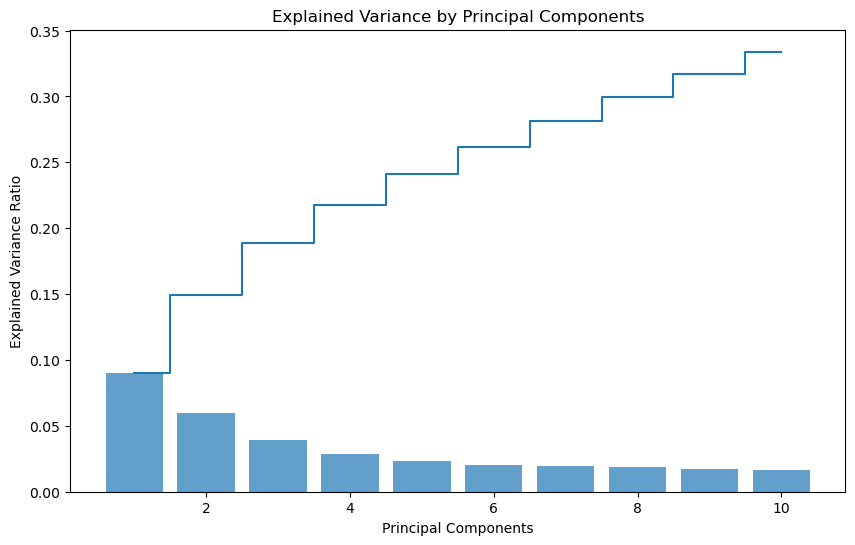

c:\Anaconda\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Anaconda\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



Evaluation Results:
Explained Variance Ratio: [0.09002556 0.05965417 0.03937031 0.02847861 0.02356376 0.02052596
 0.01962287 0.0187358  0.0174189  0.01658565]
Cumulative Explained Variance: [0.09002556 0.14967973 0.18905004 0.21752865 0.24109242 0.26161838
 0.28124125 0.29997705 0.31739595 0.3339816 ]
Reconstruction Error: 0.6660184031178052
Silhouette Score: 0.17867718754230874


In [38]:
# Example usage
results_mi_corr = evaluate_pca_indepth(data, n_components=10, color_column='Sensor ID', n_clusters=3)

print("Evaluation Results:")
print(f"Explained Variance Ratio: {results_mi_corr['explained_variance_ratio']}")
print(f"Cumulative Explained Variance: {results_mi_corr['cumulative_explained_variance']}")
print(f"Reconstruction Error: {results_mi_corr['reconstruction_error']}")
print(f"Silhouette Score: {results_mi_corr['silhouette_score']}")

## 5.2 Evaluate Feature selection performance

The result look not amazing... so we will be looking into product after the feature selection.
1. Batch Correlation 
2. lazy Correlation 
3. MI-Batch Correlation with top 10 features
4. MI-Batch Correlation with top 50 features
5. MI-lazy Correlation with top 10 features
6. MI-lazy Correlation with top 50 features

### 5.2.1. Batch Correlation 

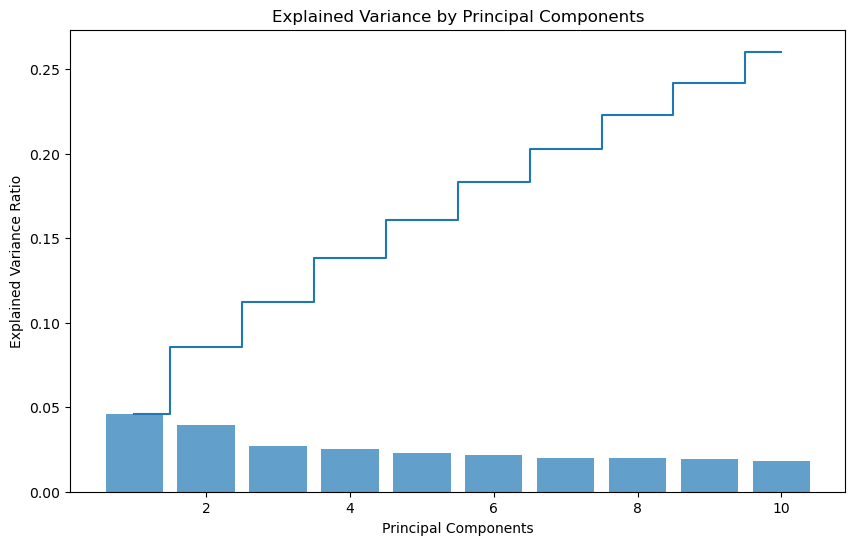

c:\Anaconda\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Anaconda\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



Evaluation Results:
Explained Variance Ratio: [0.0462463  0.03927413 0.0269175  0.02557244 0.02305301 0.02191982
 0.02003894 0.0197215  0.01922165 0.01837375]
Cumulative Explained Variance: [0.0462463  0.08552042 0.11243792 0.13801036 0.16106337 0.18298319
 0.20302213 0.22274363 0.24196527 0.26033902]
Reconstruction Error: 0.7396609797588053
Silhouette Score: 0.20497874606911975


In [39]:
# Example usage
results_mi_corr = evaluate_pca_indepth(df, n_components=10, color_column='Sensor ID', n_clusters=3)

print("Evaluation Results:")
print(f"Explained Variance Ratio: {results_mi_corr['explained_variance_ratio']}")
print(f"Cumulative Explained Variance: {results_mi_corr['cumulative_explained_variance']}")
print(f"Reconstruction Error: {results_mi_corr['reconstruction_error']}")
print(f"Silhouette Score: {results_mi_corr['silhouette_score']}")

### 5.2.2. lazy Correlation 

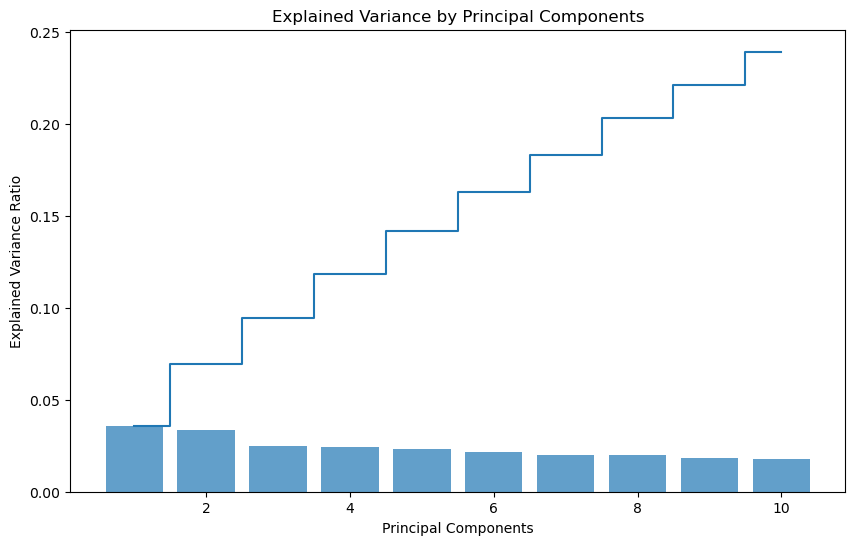

c:\Anaconda\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Anaconda\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



Evaluation Results:
Explained Variance Ratio: [0.03560133 0.03361528 0.0251078  0.02422086 0.02318076 0.0213181
 0.02005243 0.01976498 0.01838895 0.01789566]
Cumulative Explained Variance: [0.03560133 0.06921661 0.09432441 0.11854527 0.14172603 0.16304413
 0.18309657 0.20286154 0.22125049 0.23914615]
Reconstruction Error: 0.7608538487500055
Silhouette Score: 0.1692968913233723


In [40]:
# Example usage
results_mi_corr = evaluate_pca_indepth(df_corr, n_components=10, color_column='Sensor ID', n_clusters=3)

print("Evaluation Results:")
print(f"Explained Variance Ratio: {results_mi_corr['explained_variance_ratio']}")
print(f"Cumulative Explained Variance: {results_mi_corr['cumulative_explained_variance']}")
print(f"Reconstruction Error: {results_mi_corr['reconstruction_error']}")
print(f"Silhouette Score: {results_mi_corr['silhouette_score']}")

### 5.2.3. MI-Batch Correlation with top 10 features

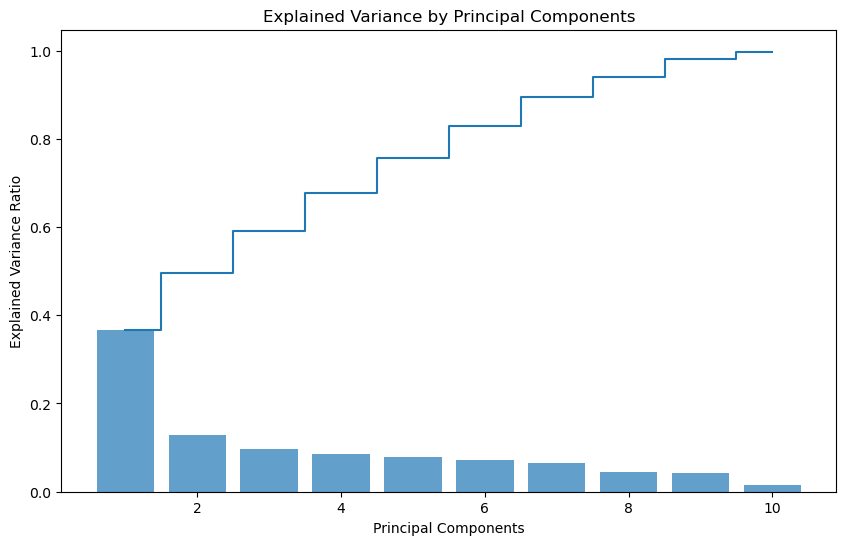

c:\Anaconda\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Anaconda\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



Evaluation Results:
Explained Variance Ratio: [0.36719803 0.12838145 0.09607064 0.0857444  0.07910657 0.07217473
 0.06596746 0.04504399 0.04193431 0.01581344]
Cumulative Explained Variance: [0.36719803 0.49557949 0.59165013 0.67739453 0.75650109 0.82867582
 0.89464328 0.93968727 0.98162158 0.99743502]
Reconstruction Error: 0.002564980584130954
Silhouette Score: 0.27318555384935184


In [41]:
# Example usage
results_mi = evaluate_pca_indepth(df_mi, n_components=10, color_column='Sensor ID', n_clusters=3)

print("Evaluation Results:")
print(f"Explained Variance Ratio: {results_mi['explained_variance_ratio']}")
print(f"Cumulative Explained Variance: {results_mi['cumulative_explained_variance']}")
print(f"Reconstruction Error: {results_mi['reconstruction_error']}")
print(f"Silhouette Score: {results_mi['silhouette_score']}")

### 5.2.4. MI-Batch Correlation with top 50 features

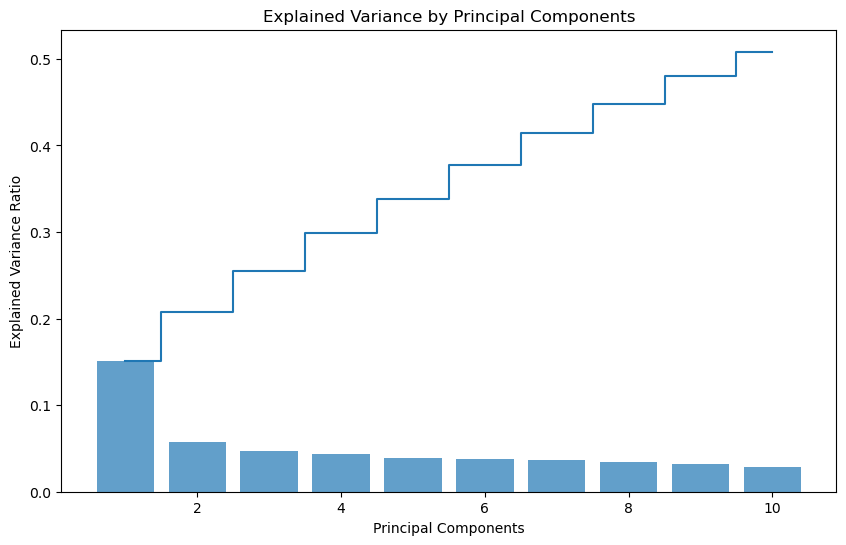

Evaluation Results:
Explained Variance Ratio: [0.15079823 0.05721652 0.04722583 0.0438035  0.03951064 0.03833813
 0.03694622 0.03400183 0.03198352 0.02844774]
Cumulative Explained Variance: [0.15079823 0.20801475 0.25524058 0.29904408 0.33855473 0.37689286
 0.41383908 0.44784091 0.47982443 0.50827218]
Reconstruction Error: 0.491727821987435
Silhouette Score: 0.14394365932477485


c:\Anaconda\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Anaconda\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [42]:
# Example usage
results_mi_corr = evaluate_pca_indepth(df_mi_50, n_components=10, color_column='Sensor ID', n_clusters=3)

print("Evaluation Results:")
print(f"Explained Variance Ratio: {results_mi_corr['explained_variance_ratio']}")
print(f"Cumulative Explained Variance: {results_mi_corr['cumulative_explained_variance']}")
print(f"Reconstruction Error: {results_mi_corr['reconstruction_error']}")
print(f"Silhouette Score: {results_mi_corr['silhouette_score']}")

### 5.2.5. MI-lazy Correlation with top 10 features

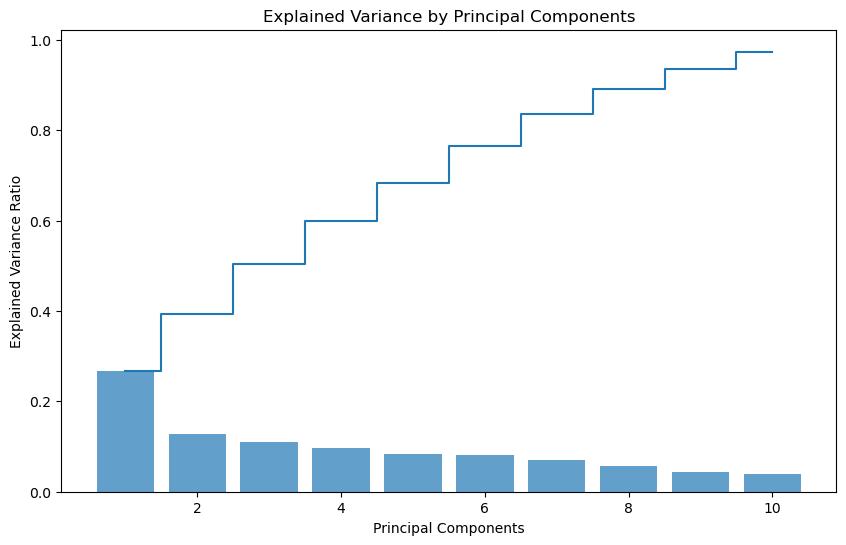

c:\Anaconda\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Anaconda\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



Evaluation Results:
Explained Variance Ratio: [0.26631374 0.12726835 0.11033288 0.09569921 0.08316913 0.08132371
 0.07098348 0.05724721 0.04274849 0.03875885]
Cumulative Explained Variance: [0.26631374 0.39358209 0.50391498 0.59961419 0.68278331 0.76410702
 0.83509051 0.89233771 0.9350862  0.97384505]
Reconstruction Error: 0.026154946550459905
Silhouette Score: 0.2801988530962951


In [43]:
# Example usage
results_mi_corr = evaluate_pca_indepth(df_mi_corr, n_components=10, color_column='Sensor ID', n_clusters=3)

print("Evaluation Results:")
print(f"Explained Variance Ratio: {results_mi_corr['explained_variance_ratio']}")
print(f"Cumulative Explained Variance: {results_mi_corr['cumulative_explained_variance']}")
print(f"Reconstruction Error: {results_mi_corr['reconstruction_error']}")
print(f"Silhouette Score: {results_mi_corr['silhouette_score']}")


### 5.2.6. MI-lazy Correlation with top 50 features

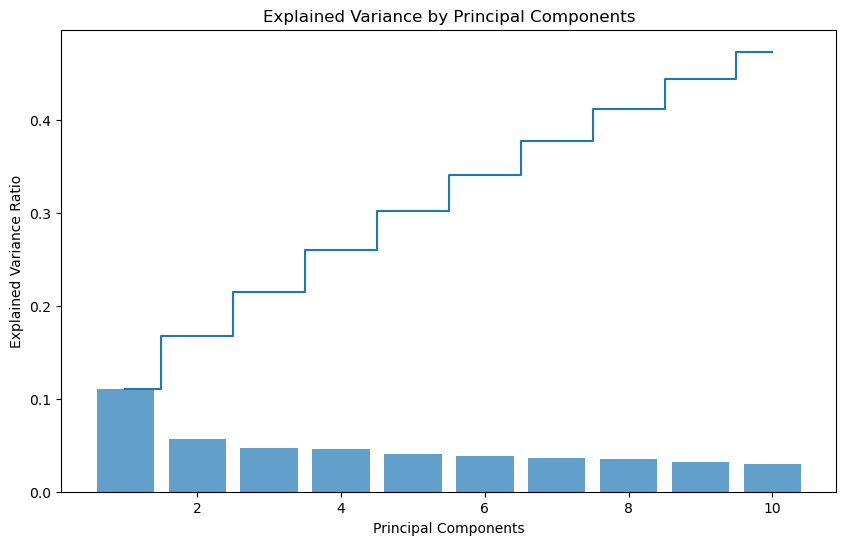

c:\Anaconda\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Anaconda\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



Evaluation Results:
Explained Variance Ratio: [0.11069751 0.05716564 0.04706627 0.0457888  0.04100152 0.03885217
 0.03645622 0.03529676 0.03182913 0.02951474]
Cumulative Explained Variance: [0.11069751 0.16786315 0.21492943 0.26071822 0.30171974 0.34057191
 0.37702813 0.4123249  0.44415403 0.47366877]
Reconstruction Error: 0.5263312328879273
Silhouette Score: 0.12449759986086942


In [44]:
# Example usage
results_mi_corr = evaluate_pca_indepth(df_mi_corr_50, n_components=10, color_column='Sensor ID', n_clusters=3)

print("Evaluation Results:")
print(f"Explained Variance Ratio: {results_mi_corr['explained_variance_ratio']}")
print(f"Cumulative Explained Variance: {results_mi_corr['cumulative_explained_variance']}")
print(f"Reconstruction Error: {results_mi_corr['reconstruction_error']}")
print(f"Silhouette Score: {results_mi_corr['silhouette_score']}")


### 5.2.7. MI-lazy Correlation with top 25 features 

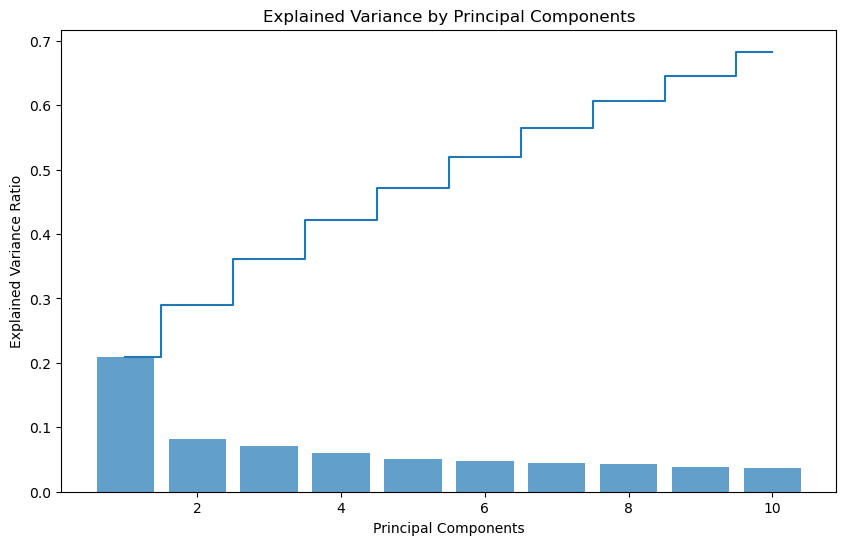

c:\Anaconda\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Anaconda\envs\datascience\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



Evaluation Results:
Explained Variance Ratio: [0.11069751 0.05716564 0.04706627 0.0457888  0.04100152 0.03885217
 0.03645622 0.03529676 0.03182913 0.02951474]
Cumulative Explained Variance: [0.11069751 0.16786315 0.21492943 0.26071822 0.30171974 0.34057191
 0.37702813 0.4123249  0.44415403 0.47366877]
Reconstruction Error: 0.5263312328879273
Silhouette Score: 0.12449759986086942


In [45]:
# Example usage
results_mi_corr_25 = evaluate_pca_indepth(df_mi_corr_25, n_components=10, color_column='Sensor ID', n_clusters=3)

print("Evaluation Results:")
print(f"Explained Variance Ratio: {results_mi_corr['explained_variance_ratio']}")
print(f"Cumulative Explained Variance: {results_mi_corr['cumulative_explained_variance']}")
print(f"Reconstruction Error: {results_mi_corr['reconstruction_error']}")
print(f"Silhouette Score: {results_mi_corr['silhouette_score']}")


## 5.3 Results analysis

The best one so far was "MI-lazy Correlation with top 10 features"

Overall, the PCA analysis shows effective dimensionality reduction with a good balance between retaining variance and reducing dimensions. The explained variance and reconstruction error indicate that the essential data structure is well-preserved. The silhouette score suggests there is some clustering structure, but it might need further refinement.

In [46]:
df_mi_corr

23_16800_mean_middle  23_6000_mean_middle  18_16800_mean_middle  \
0             1302.076923          1328.200000           1069.285714   
1             1247.560000          1235.000000            954.200000   
2             1296.674419          1296.511111           1020.920000   
3             1319.000000          1318.652174           1031.000000   
4             1332.760000          1332.920000           1045.697674   
..                    ...                  ...                   ...   
205           1307.170213          1307.000000           1026.760000   
206           1296.444444          1304.920000           1009.883721   
207           1345.080000          1335.833333           1053.875000   
208           1309.000000          1303.750000           1018.744681   
209            722.346939          1305.080000           1008.920000   

     23_10000_mean_middle  28_16800_mean_middle  18_3000_mean_middle  \
0             1303.000000           1590.384615          1069.240000   
1             1235.000000           1522.920000           967.260870   
2             1297.212766           1584.244444          1007.000000   
3             1317.640000           1628.469388          1028.840000   
4             1333.480000           1587.480000          1047.244898   
..                    ...                   ...                  ...   
205           1307.000000           1580.250000          1025.960000   
206           1296.727273           1582.090909          1009.720000   
207           1334.707317           1617.400000          1064.440000   
208           1303.000000           1567.000000          1018.520000   
209           1304.120000           1562.520000          1028.043478   

     13_6000_mean_middle  13_3000_mean_middle  13_10000_mean_middle  \
0             827.000000           827.000000            827.000000   
1             679.000000           679.000000            679.640000   
2             717.240000           718.040000            717.880000   
3             736.920000           737.160000            737.080000   
4             743.000000           741.880000            743.000000   
..                   ...                  ...                   ...   
205           709.480000           709.122449            709.560000   
206           720.520000           720.120000            719.897959   
207           759.408163           759.000000            759.000000   
208           723.000000           723.000000            722.200000   
209           715.000000           714.583333            715.000000   

     53_6000_mean_middle  Sensor ID  
0            2995.205128          1  
1            2951.000000          2  
2            3000.440000          3  
3            2999.000000          4  
4            3034.760000          5  
..                   ...        ...  
205          3027.160000        207  
206          2998.760000        208  
207          3046.120000        209  
208          3003.480000        210  
209          2990.040000        211  

[210 rows x 11 columns]

one thing that caught attention is the nature of this project is anomaly detection. If a PCA model reconstructs normal data well, it does not necessarily mean it will reconstruct outliers or anomalies well. In fact, the assumption in using reconstruction error for anomaly detection is that the PCA model, which is trained on normal data, will not reconstruct anomalies as well, leading to higher reconstruction errors for anomalous data points.

The Silhouette Score is generally used to evaluate the quality of clustering. While it provides insights into how well-defined clusters are, it is not directly designed for anomaly detection. We have to keep this in mind.

# 6.0 Inspect data to verify the preliminary result

In this section we will try to invesitage data point that were seems to be outlier from "MI-lazy Correlation with top 10 features".

In [9]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

# Load the dataset
file_path = '../processed_data/all_data_v4-1-1_cleaned_sensor211.csv'
all_cleaned_df = pd.read_csv(file_path)
all_cleaned_df = all_cleaned_df.drop("Unnamed: 0",axis=1)
all_cleaned_df.head()

Trial  Ping Duration  Distance (cm)  Ping Time (us)  Delay (us)    Steps  \
0      0           3476          14.51             827       16800  10440.0   
1      1           3468          14.51             827       16800  10440.0   
2      2           3472          14.44             823       16800  10440.0   
3      3           3476          14.51             827       16800  10440.0   
4      4           3476          14.51             827       16800  10440.0   

   Arduino ID  Sensor ID  Range (cm)  Sensor length (cm)  ... side a (cm)  \
0           1          1          13                 0.8  ...        18.3   
1           1          1          13                 0.8  ...        18.3   
2           1          1          13                 0.8  ...        18.3   
3           1          1          13                 0.8  ...        18.3   
4           1          1          13                 0.8  ...        18.3   

   side b (cm)  side c (cm)  Angle on YZ plane  Sensor Configuration  \
0         18.3            0                  0                   HTR   
1         18.3            0                  0                   HTR   
2         18.3            0                  0                   HTR   
3         18.3            0                  0                   HTR   
4         18.3            0                  0                   HTR   

   Sensor Angle Surface material  Surface Length (cm) Surface Width (cm)  \
0            90             wood                   31               30.5   
1            90             wood                   31               30.5   
2            90             wood                   31               30.5   
3            90             wood                   31               30.5   
4            90             wood                   31               30.5   

   side g (cm)  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  

[5 rows x 22 columns]

In [49]:
# Function to visualize the effect of delay and range on ping time
def visualize_effect_on_ping_time_sensors(df, target = 0):
    """
    Visualize the effect of delay and range on ping time.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    """
    # Group by sensor ID, delay, and range, then calculate the mean ping time
    grouped_df = df.groupby(['Sensor ID', 'Delay (us)', 'Range (cm)'])['Ping Time (us)'].mean().reset_index()
    # Create individual plots for each range
    unique_sensors = grouped_df['Sensor ID'].unique()
    
    if target in unique_sensors:
        subset_df = grouped_df[grouped_df['Sensor ID'] == target]
        plt.figure(figsize=(14, 10))
        sns.barplot(
            x='Range (cm)', 
            y='Ping Time (us)', 
            hue='Delay (us)', 
            data=subset_df
        )
        
        plt.title(f'Effect of Delay on Ping Time by Range on Sensor {target}')
        plt.xlabel('Range (cm)')
        plt.ylabel('Mean Ping Time (us)')
        plt.legend(title='Delay (us)')
        plt.xticks(rotation=45)
        # Adjust y-axis limits and ticks for better precision
        min_ping_time = subset_df['Ping Time (us)'].min()
        max_ping_time = subset_df['Ping Time (us)'].max()
        plt.ylim(min_ping_time - 50, max_ping_time + 50)  # Adjust the limits as needed
        plt.yticks(range(int(min_ping_time) - 50, int(max_ping_time) + 50, 50))  # Adjust the step as needed
        plt.show()

def visualize_lineplot_ping_time_with_variability(df, target = []):
    """
    Visualize the effect of range on ping time for each delay separately with variability.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    """
    # Group by sensor ID, delay, and range, then calculate the mean and standard deviation of ping time
    grouped_df = df.groupby(['Sensor ID', 'Delay (us)', 'Range (cm)']).agg(
        mean_ping_time=('Ping Time (us)', 'mean'),
        std_ping_time=('Ping Time (us)', 'std')
    ).reset_index()

    target_df = grouped_df[grouped_df['Sensor ID'].isin(target)]
    # Get unique delays
    unique_delays = target_df['Delay (us)'].unique()

    for delay in unique_delays:
        subset_df = target_df[target_df['Delay (us)'] == delay]

        fig = px.line(
            subset_df,
            x='Range (cm)',
            y='mean_ping_time',
            color='Sensor ID',
            markers=True,
            title=f'Effect of Range on Ping Time for Delay {delay} us with Variability'
        )

        # Adding error bars
        for sensor_id in subset_df['Sensor ID'].unique():
            sensor_data = subset_df[subset_df['Sensor ID'] == sensor_id]
            fig.add_trace(
                go.Scatter(
                    x=sensor_data['Range (cm)'],
                    y=sensor_data['mean_ping_time'],
                    mode='lines+markers',
                    name=f'Sensor {sensor_id}',
                    error_y=dict(
                        type='data',
                        array=sensor_data['std_ping_time'],
                        visible=True
                    )
                )
            )

        # Plot reference line
        ranges = np.linspace(subset_df['Range (cm)'].min(), subset_df['Range (cm)'].max(), 100)
        reference_ping_times = 57 * ranges
        fig.add_trace(
            go.Scatter(
                x=ranges,
                y=reference_ping_times,
                mode='lines',
                line=dict(color='red', dash='dash'),
                name='Reference Line'
            )
        )

        fig.update_layout(
            xaxis_title='Range (cm)',
            yaxis_title='Mean Ping Time (us)',
            legend_title='Sensor ID',
            template='plotly_white'
        )

        fig.show()
    

## 6.1 Look sensor result based on "MI-lazy Correlation with top 10 features"

From the visual inspecting the section 5.2.5 visualiation there were few things should be investigated.

1. sensor 20, and 75  seems to be outliers
2. Sensor 84,32, 100, 90 seems to form a strong community
3. Sensor 55, 76 and 61 seems to form a weak cluster
4. Sensor 68, 9 and 97 may have form a cluster
5. Sensor 6, and 58 may have form a cluster

After these individual point's investigation I will proceed further with comparing how each of those different from other "community".

Top 10 features are followings:

['23_16800_mean_middle', '18_16800_mean_middle', '13_6000_mean_middle',
'13_3000_mean_middle', '23_6000_mean_middle', '18_3000_mean_middle',
'28_16800_mean_middle', '53_8000_mean_middle', '13_10000_mean_middle',
'53_6000_mean_middle', 'Sensor ID']

### Outlier Investigation: Sensor ID 20,and 75

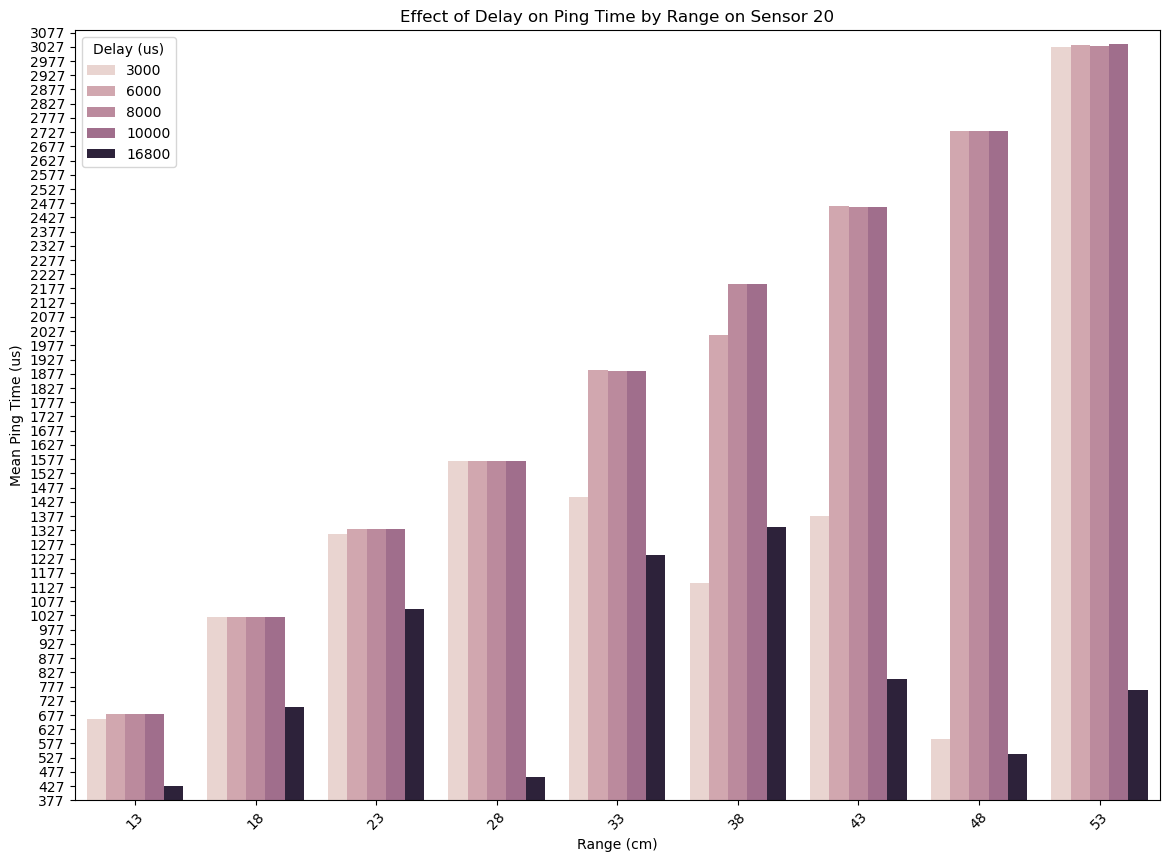

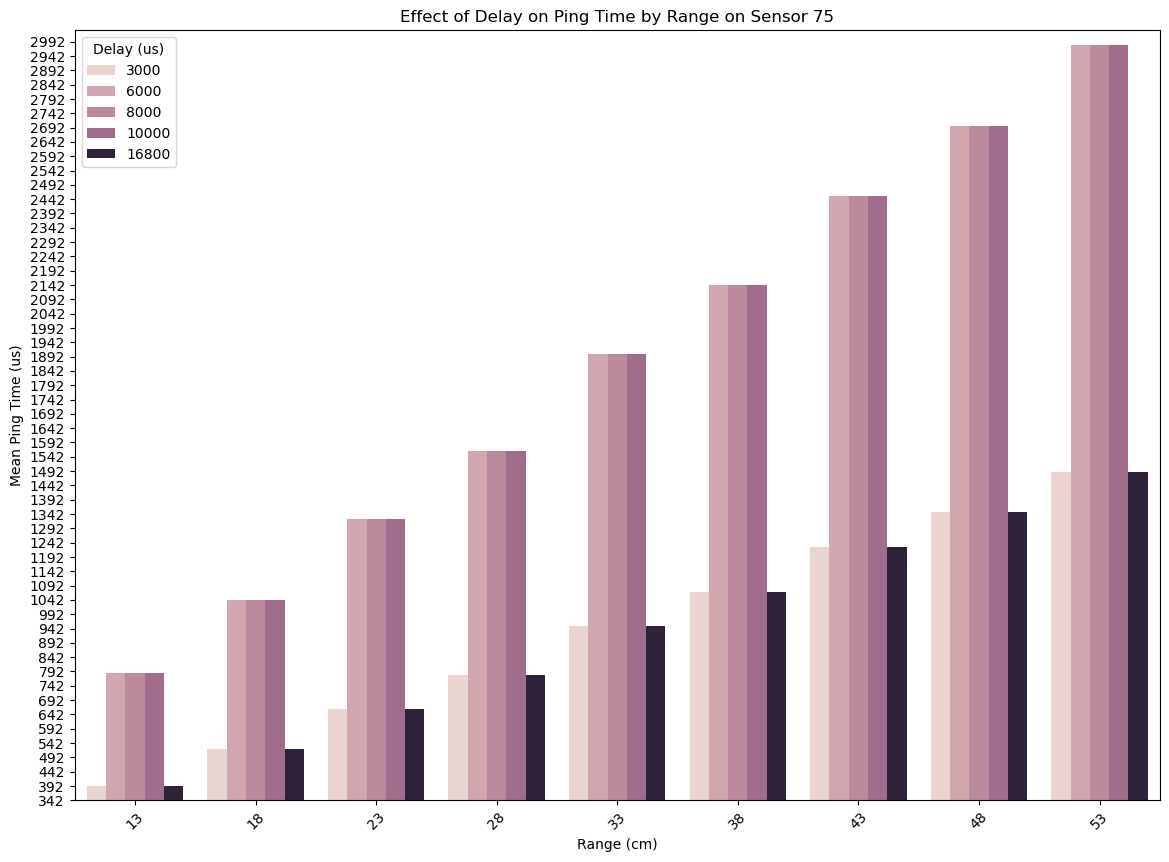

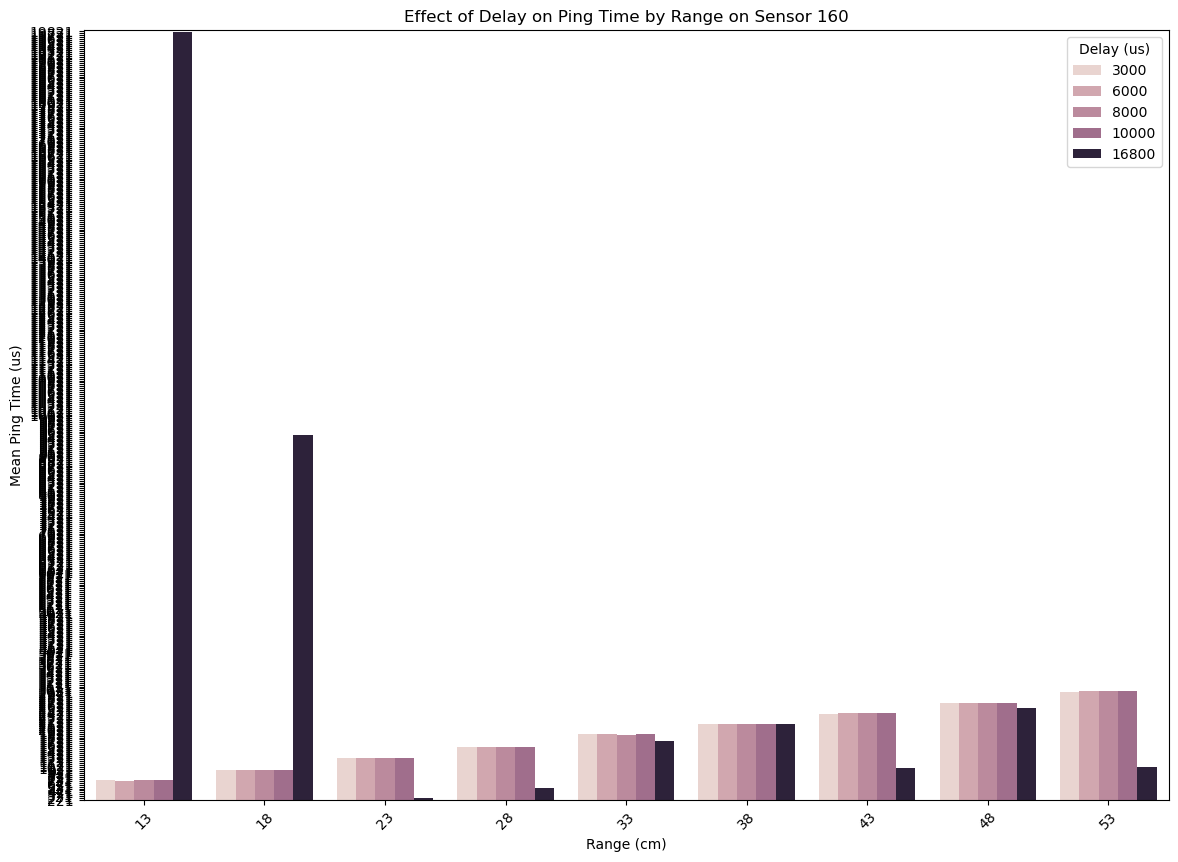

In [50]:
outlier_list = [20,75,160]
for sensor_id in outlier_list:
    visualize_effect_on_ping_time_sensors(all_cleaned_df,sensor_id)

In [51]:
visualize_lineplot_ping_time_with_variability(all_cleaned_df,outlier_list)

Characteristic of the variability are prominent when the delay is 16800us, 6000us, 3000us.

### Strong Community: Sensor 84,32, 100, 90

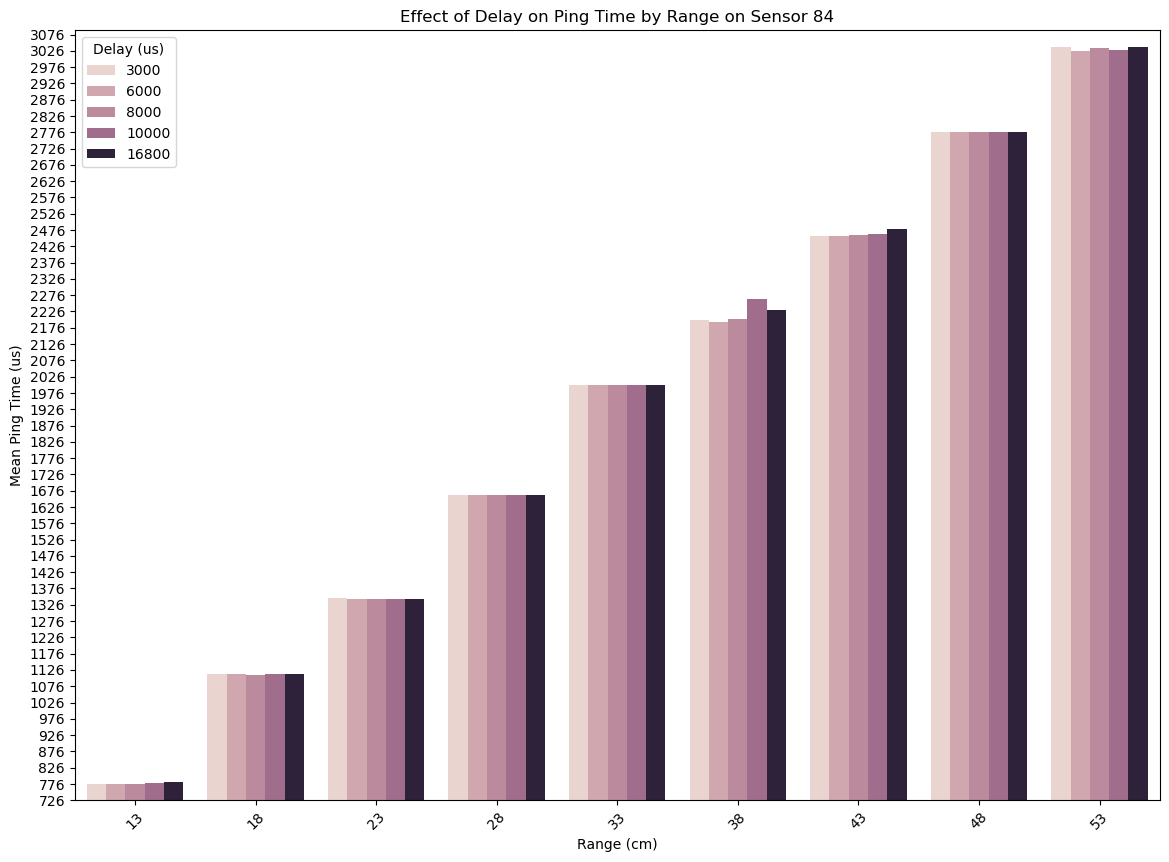

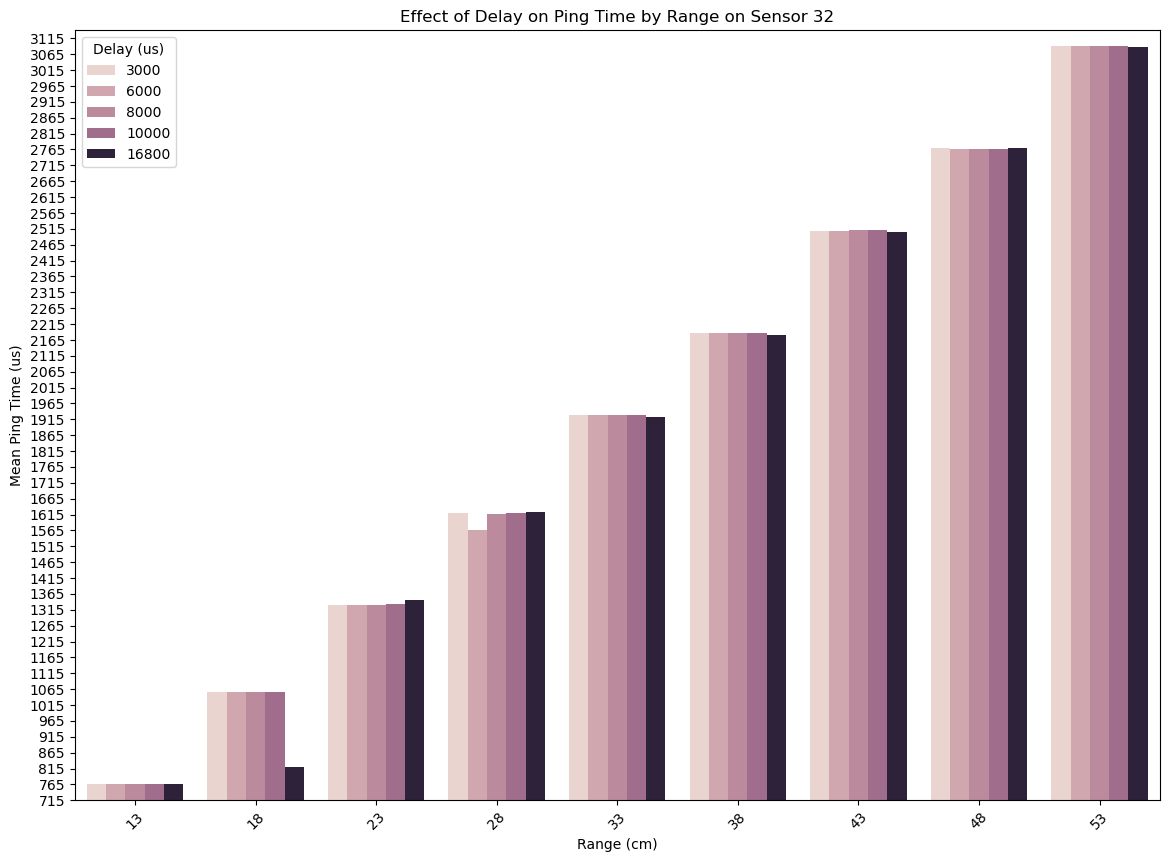

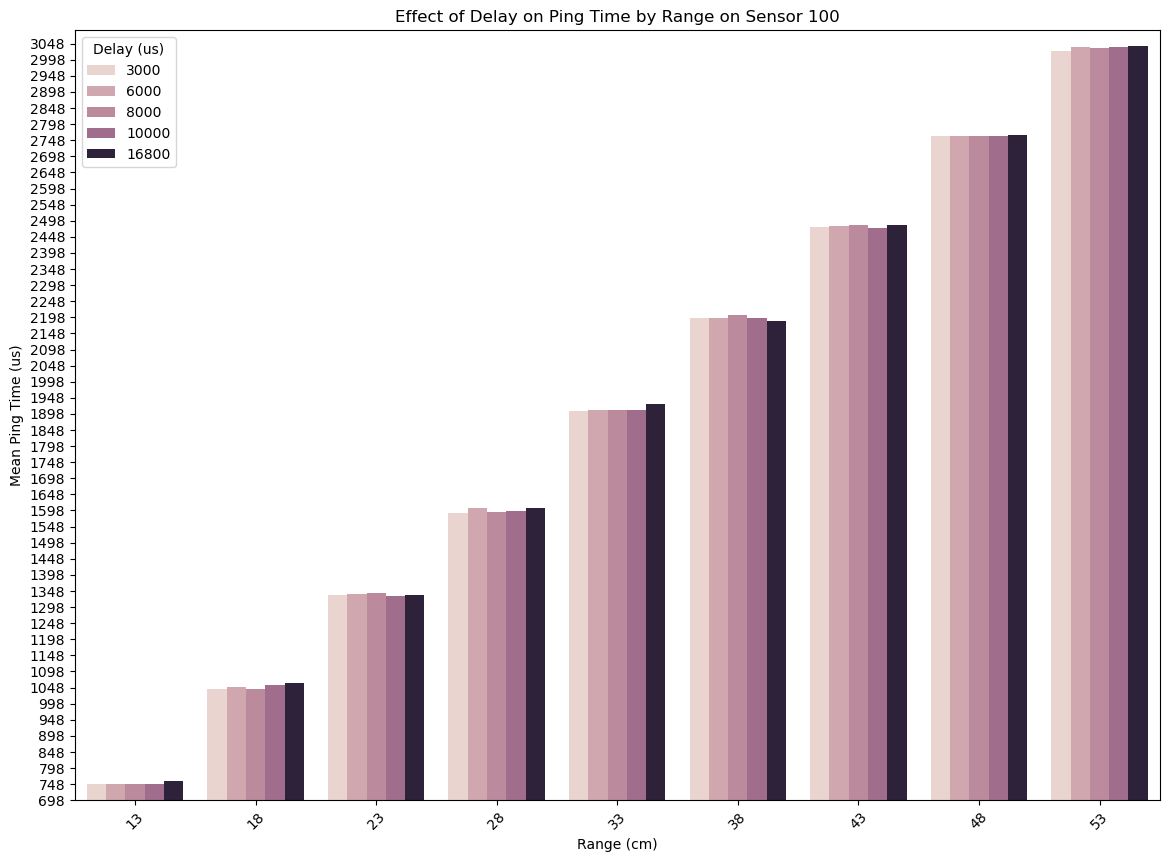

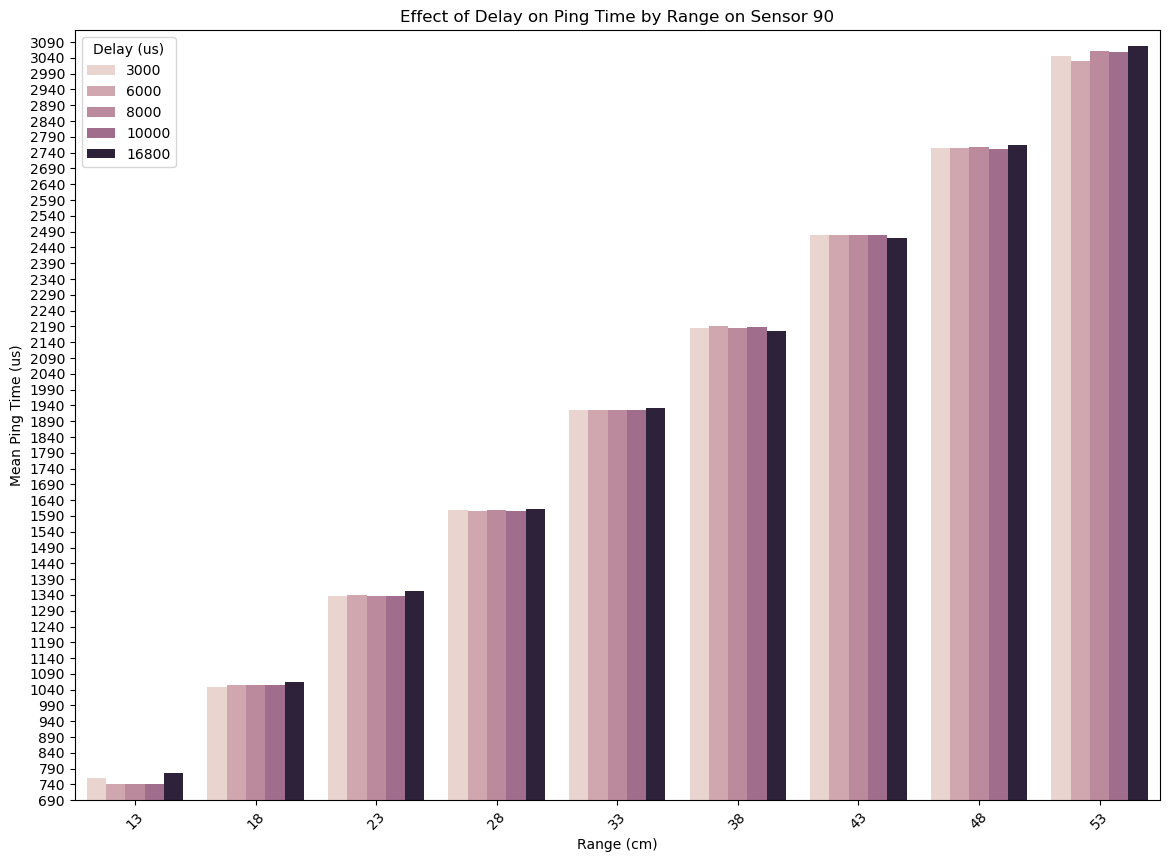

In [52]:
strong_community = [84,32, 100, 90]
for sensor_id in strong_community:
    visualize_effect_on_ping_time_sensors(all_cleaned_df,sensor_id)

In [53]:
visualize_lineplot_ping_time_with_variability(all_cleaned_df,strong_community)

They seems to have strong lienar relationship however sensor 32 have some malfunction when the range is close but in general they seems to be similar. However it is bit worrying that sensor 32 seems to be forming a cluster with the others.

**Feature engineering idea:** I can do another feature engineering where index = range_delay_mean_quarltile * range_delay_freq_quarltile

### Weak cluster1: Sensor 55, 76 and 61

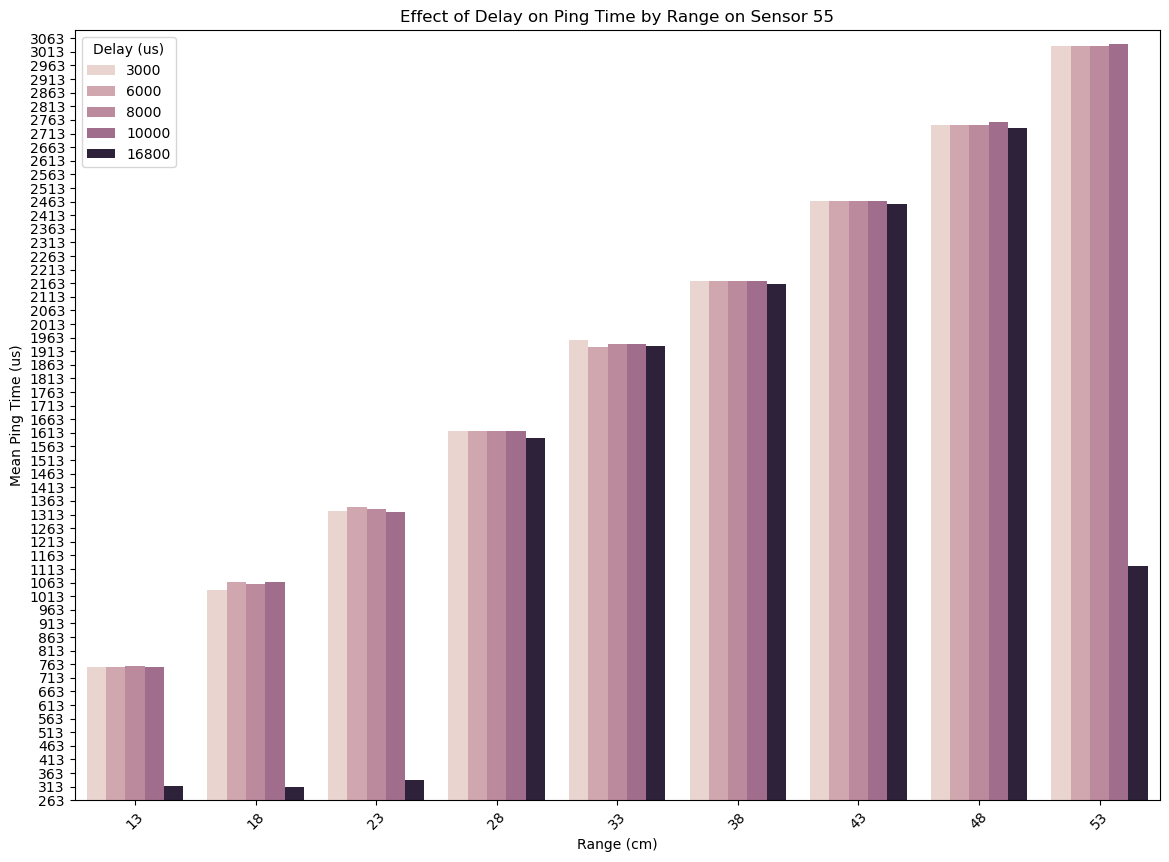

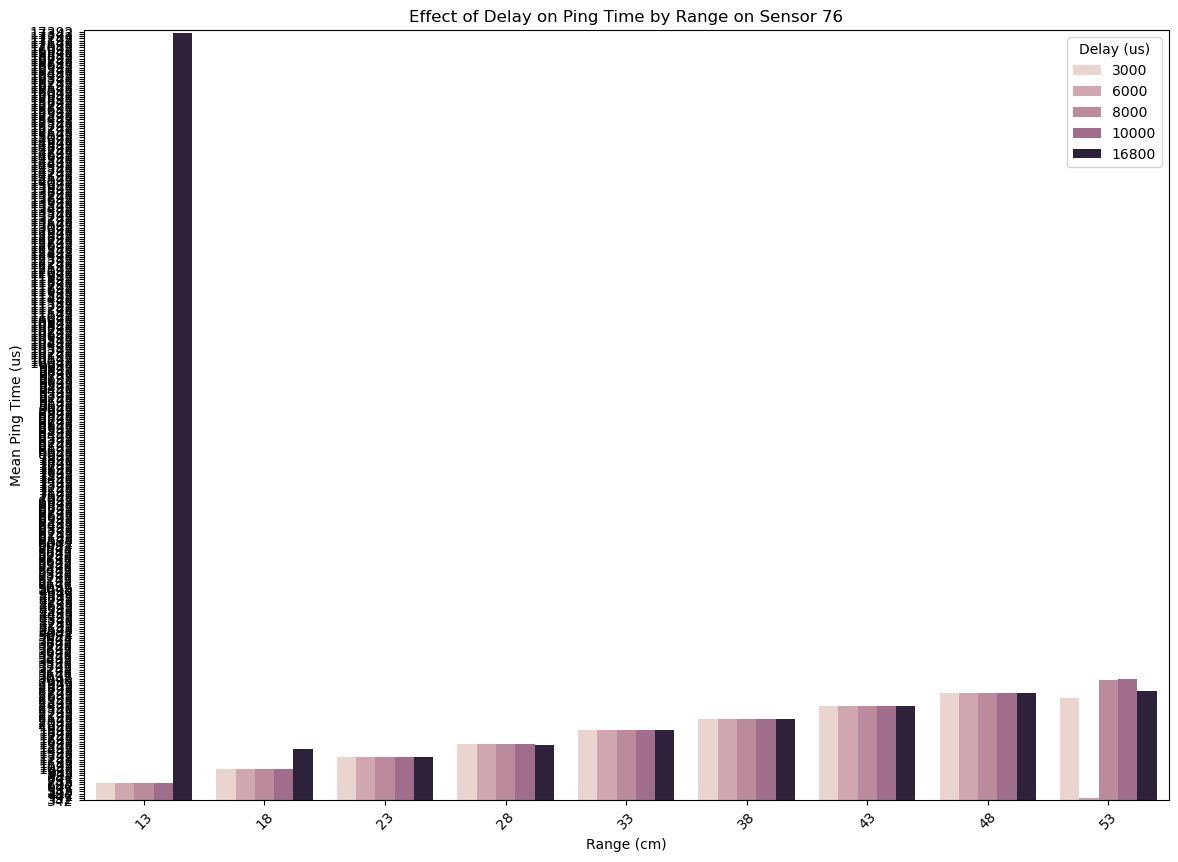

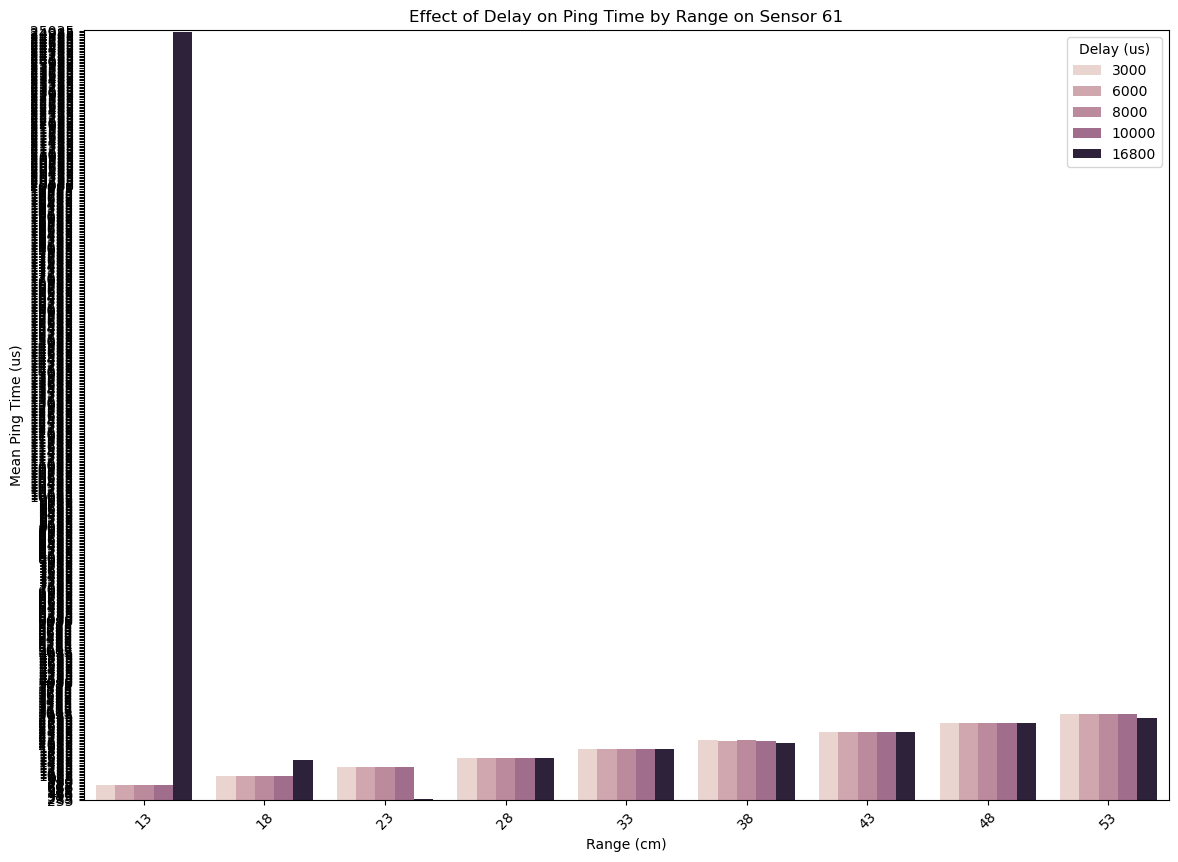

In [54]:
weak_community_1 = [55,76,61]
for sensor_id in weak_community_1:
    visualize_effect_on_ping_time_sensors(all_cleaned_df,sensor_id)

In [55]:
visualize_lineplot_ping_time_with_variability(all_cleaned_df,weak_community_1)

This cluster seems reasonable for the delay 16800us where in close range they act weird output and they tend to overestimate things. However sensor 76 on 3000us and 6000us they seems to have abnormal result and I dont think they are accounting this factor. 

### Weak cluster2: Sensor 68, 9 and 97 

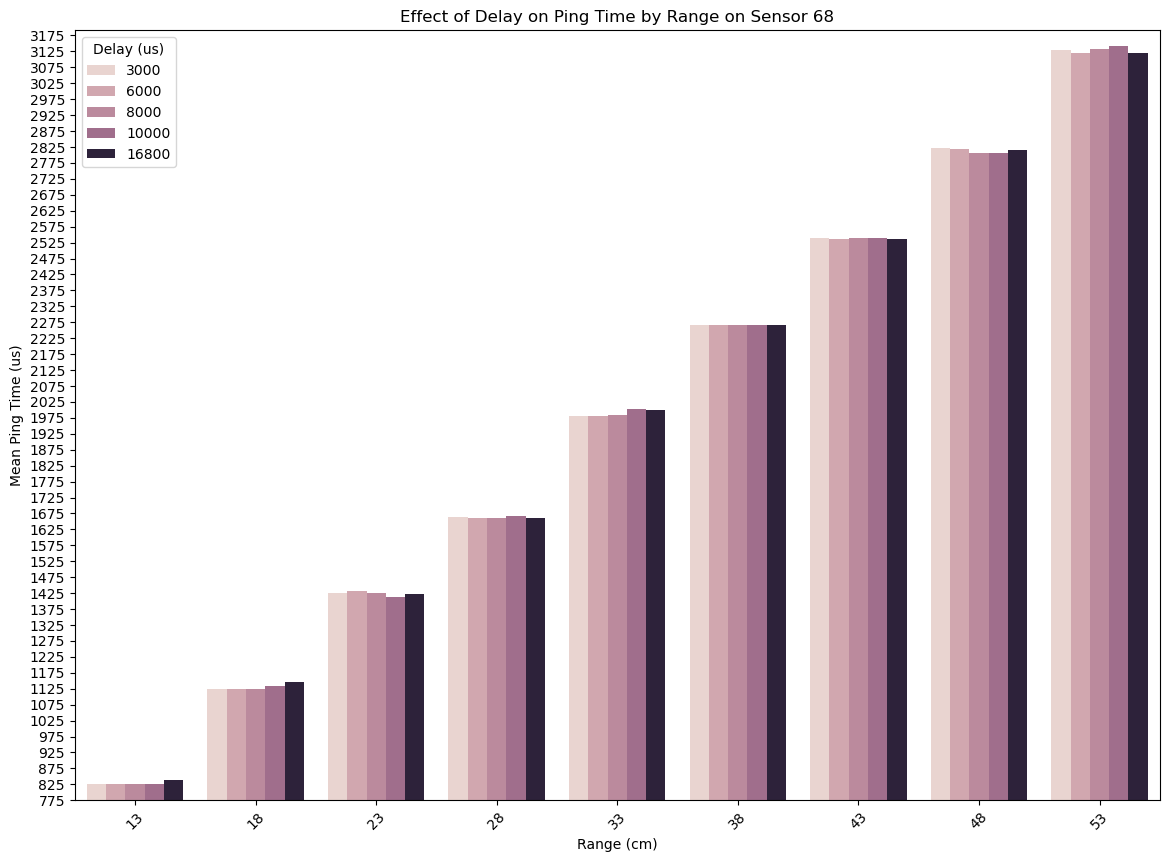

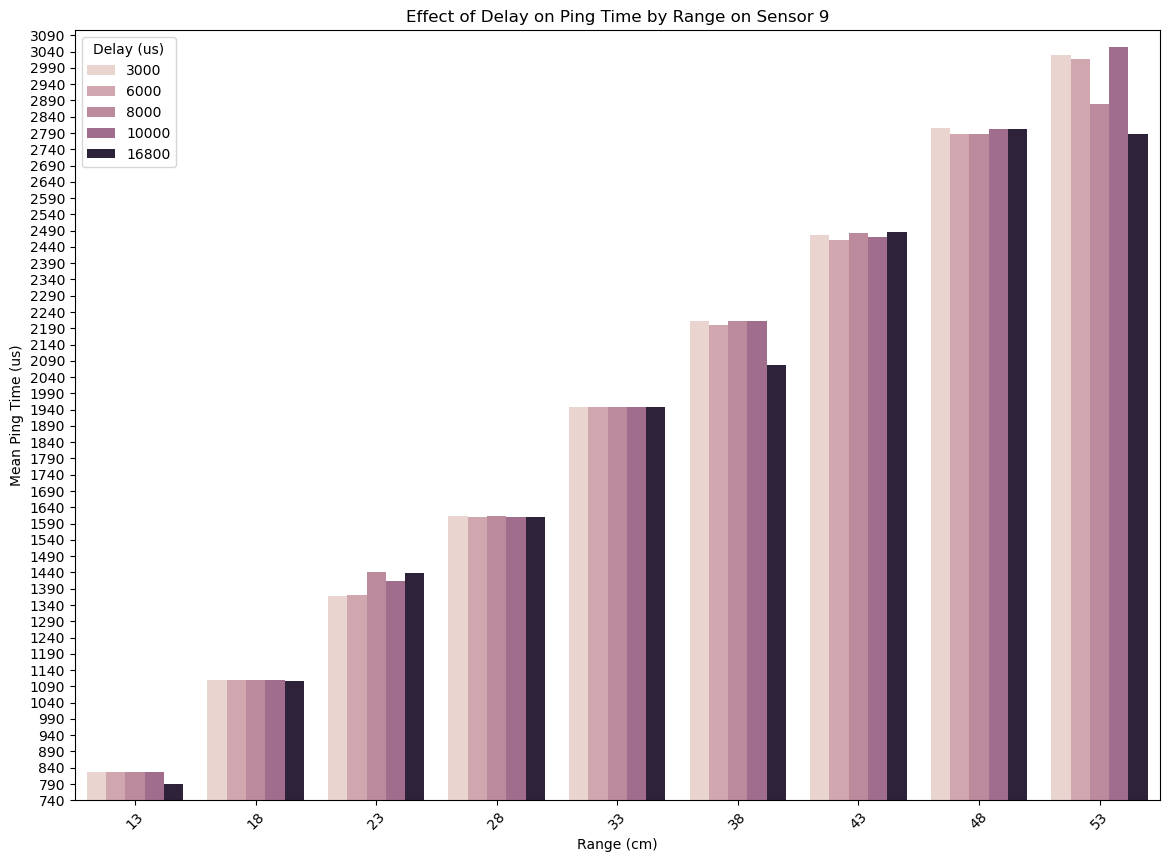

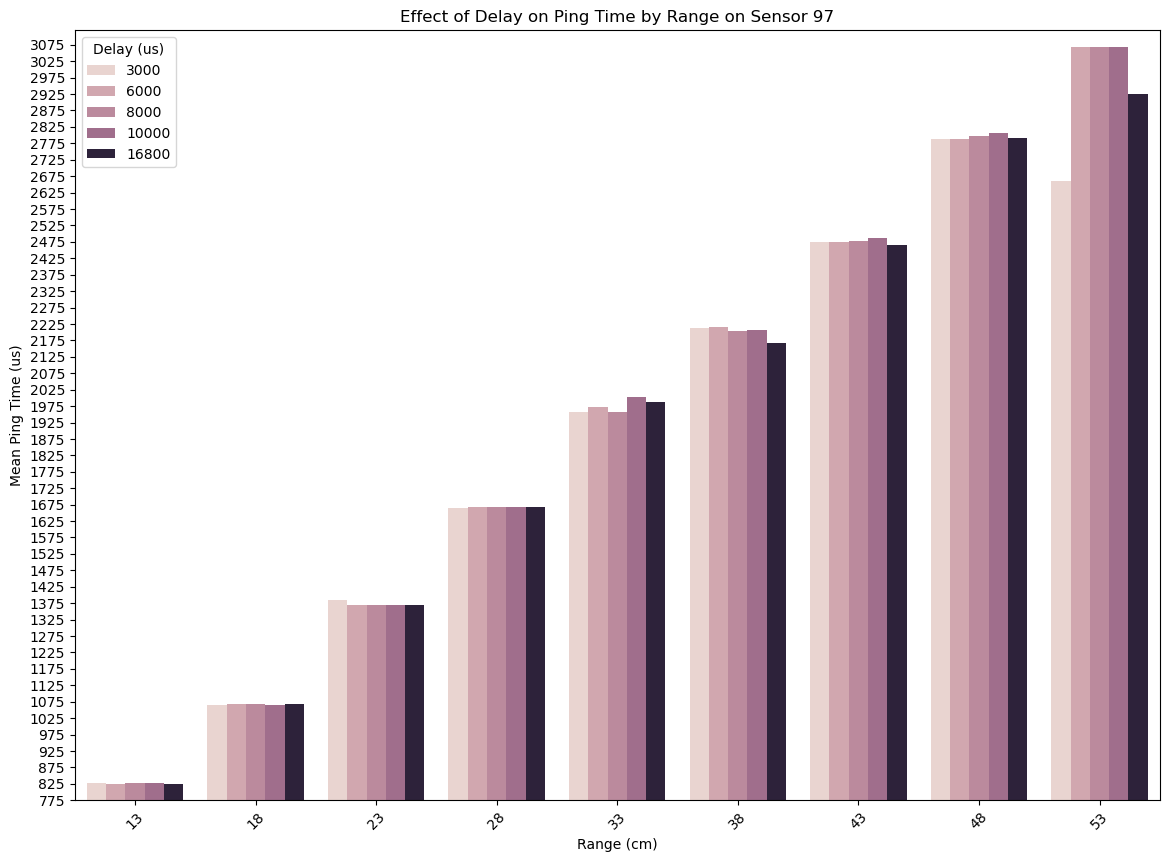

In [56]:
weak_community_2 = [68, 9, 97 ]
for sensor_id in weak_community_2:
    visualize_effect_on_ping_time_sensors(all_cleaned_df,sensor_id)

In [57]:
visualize_lineplot_ping_time_with_variability(all_cleaned_df,weak_community_2)

This cluster is the sensor that are overestimating and seems like the cluster correctly capture the characteristics.

### Weak cluster3: Sensor 6, and 58

In [58]:
weak_community_2 = [58,6 ]
visualize_lineplot_ping_time_with_variability(all_cleaned_df,weak_community_2)

This may have been human error since theres only 3 dimension we can look at which lead me to investigate sophisticated clustering methods.

## 6.2 Look sensor result based on "MI-batch Correlation with top 10 features"

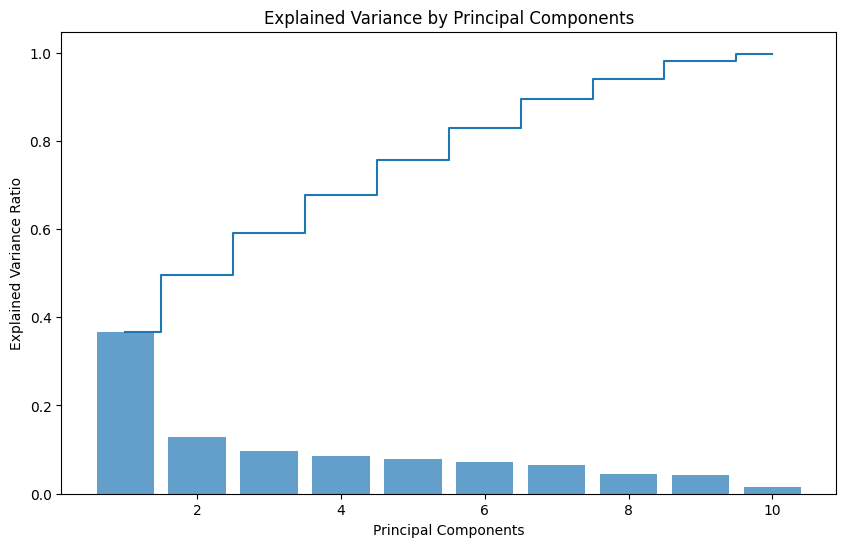

/Users/jihoonchung/anaconda3/envs/datascience/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [340]:
# Example usage
results_mi = evaluate_pca_indepth(df_mi, n_components=10, color_column='Sensor ID', n_clusters=3)

From the visual inspecting the section 5.2.3 visualiation there were few things should be investigated.

1. Outlier: sensor 68, 9, 55,75, 163, 2,34
2. Strong community Upper left: 152,147,153,165
3. Strong community Lower left: 18,14,41,48
4. Strong community Lower right: 11,23,29,16
5. Strong community (0,3.8): 65,70,81,1,10
6. Weak community (-2,2): 124,64,146,122
7. Weak community (-4.5,-1.8): 94,86,77,47


After these individual point's investigation I will proceed further with comparing how each of those different from other "community".

### 1. Outlier: sensor 68, 9, 55,75, 163, 2,34

In [325]:
outliers = [68, 9, 55,75, 163, 2,34]
visualize_lineplot_ping_time_with_variability(all_cleaned_df,outliers)

Based on the visual analysis they seems to still portray linear relationship but they were like outliers since they are off from the reference line consistently.

### 2. Strong community Upper left: 152,147,153,165


In [326]:
Strong_community_Upper_left = [152,147,153,165 ]
visualize_lineplot_ping_time_with_variability(all_cleaned_df,Strong_community_Upper_left)

They all 

### 3. Strong community Lower left: 18,14,41,48


In [327]:
Strong_community_Lower_left = [18,14,41,48]
visualize_lineplot_ping_time_with_variability(all_cleaned_df,Strong_community_Lower_left)

### 4. Strong community Lower right: 11,23,29,16

In [328]:
Strong_community_Lower_rgiht = [11,23,29,16]
visualize_lineplot_ping_time_with_variability(all_cleaned_df,Strong_community_Lower_rgiht)

### 5. Strong community (3.8,0): 65,70,81,1,10


In [334]:
Strong_community_38_0 = [65,70,81,1,10]
visualize_lineplot_ping_time_with_variability(all_cleaned_df,Strong_community_38_0)

### Conclusion on strong community

Strong community in general based on the 2d plot clustering do have limitation. But this could also means that with current feature of 10 may not be capturing enough outlier? 

We still have to investigate further. To do so there are some ideas: 
1. we can use a down stream task to gaze the actual performance. We cna do clustering and do a analysis on each cluster.
2. We can try to do another feature engineering where we can engineer features like mean, and frequency. we can do something like unit_means * frequency but we have to be aware that some data has collected 100 per delay_range so we have to take that into account.


### 6. Weak community (-2,2): 124,64,146,122


In [330]:
Strong_community_neg2_2 = [124,64,146,122]
visualize_lineplot_ping_time_with_variability(all_cleaned_df,Strong_community_neg2_2)

### 7. Weak community (-4.5,-1.8): 95,86,77,47

In [331]:
weak_community_neg45_neg18 = [95,86,77,47]
visualize_lineplot_ping_time_with_variability(all_cleaned_df,weak_community_neg45_neg18)

### Conclusion on Weak community

Eventhough the arbitrary cluster was done through 2d plot most of them are showing similar trend surprisingly. This result further suggest to proceed with a downstream task analysis.

### 8. Investigate (0,0): Sensor 156,176

In [332]:
origins = [156,176]
visualize_lineplot_ping_time_with_variability(all_cleaned_df,origins)

Near Origin (0,0) for all delay they seems to have perfect linear relationship without any off going.

### 9. Investigate around (0,0): Sensor 164, 177,198,126,133

In [336]:
around_origins = [164,198,126,133,177]
visualize_lineplot_ping_time_with_variability(all_cleaned_df,around_origins)

Seems (0,0) corresponding to range 33cm and depending on PC2 value fluctuate data point.

For sensor 133 and 126 where PC2 value sit around -0.3 and PC1 value to be near zero seems to have a little off going at the range 33cm where they both went above the reference line.

To further investiaget this for sensor 177 and 198. Where they are around PC1 := -0.4, PC2 around 0. Sensor 177 where it was on the negative side of the PC2 had similar trend of 133,126 but for sensor 198 it seems to give opposite trend where it was below the reference line.

### 10. Compare Sensor 148,144 vs 109,113 

PC1 around -0.7 and PC2 around positive and negative 0.5 

In [339]:
left_positive_negative = [148,144, 109,113 ]
visualize_lineplot_ping_time_with_variability(all_cleaned_df,left_positive_negative)

along on the PC1 around -0.7 seems to act similarly but doesn't follow the discovery on the prior section. However be aware we are only making this anaylsis based on the 2 dimension. Further analysis should be made for whole thing.

## Next Step

Based on the analysis 
1. Try downstream task like clustering
2. Add feature that weight more on the outlier ex. unit_mean * c * frequency
3. Investigate autoencoder